In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import datetime
import seaborn as sb
%matplotlib inline

#plt.rcdefaults()

In [2]:
#initialise the number of weeks for the dataset
num_weeks = 2

#initialise the date for the first week of the dataset (week ending on start_date)
start_date = filedate = pd.Timestamp('2019-05-04 00:00:00')

#initialise the regex for the MTA turnstile url
filename_regex = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"

filelist = []

for numfiles in range (num_weeks):

    # create the appropriate filename for the week
    filedate_str = str(filedate.year)[2:4] + str(filedate.month).zfill(2) + str(filedate.day).zfill(2)
    filename = filename_regex.format(filedate_str)

    # read the file and append it to the list of files to be concacated
    #df = pd.read_csv(filename, parse_dates=['DATE'], keep_date_col=True)  
    df = pd.read_csv(filename, keep_date_col=True)
    filelist.append(df)

    # advance to the next week
    filedate += pd.Timedelta(days=7)

df = pd.concat(filelist, axis=0, ignore_index=True)

This next cell is legacy code from before we captured multiple weeks at a time

In [3]:
# turnstile_data_source = 'http://web.mta.info/developers/data/nyct/turnstile/'
    
# turnstile_filename1 = 'turnstile_190713.txt'
# #st = turnstile_data_source + '/' + turnstile_filename1

# df = pd.read_csv(turnstile_data_source + '/' + turnstile_filename1)

In [4]:
df.columns

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES',
       'EXITS                                                               '],
      dtype='object')

In [5]:
# rename columns since the last column, 'EXITS', contains trailing whitespace
df.columns = df.columns.str.replace(r'\s+', '')

df["EXITS"] = pd.to_numeric(df["EXITS"])
df["ENTRIES"] = pd.to_numeric(df["ENTRIES"])



******
#### New code to convert date and time strings to data and time datatypes, and then generate a composed datetime column

In [6]:
df['Datetime'] = pd.to_datetime(df.DATE + df.TIME, format='%m/%d/%Y%H:%M:%S')

New code that makes a dictionary for days-of-week as number to days of week as words.
Then generate a new column that provides days of any date given.

In [7]:
# We'll now get days of the week instead at a later step

# days_of_week = {0: 'Monday', 1:'Tuesday', 2:'Wednesday',3:'Thursday',4:'Friday', 5:'Saturday', 6:'Sunday'}
# df['Day_of_week'] = [days_of_week[datetime.datetime.weekday(date)] for date in df['Datetime']]
# df.sample(10)

Trying to groupby to get counter-runs isolated

In [8]:
df['Traffic_running_total']=df['ENTRIES']+df['EXITS']

In [9]:
# creating DF: grouping by unique turnstile and date to remove dups
turnstiles_4hourly = (df.groupby(["C/A", "UNIT", "SCP", "STATION","LINENAME","Datetime"],as_index=False)).Traffic_running_total.first()

In [10]:
turnstiles_4hourly.shape

(410945, 7)

In [11]:
turnstiles_4hourly.head(10)

,C/A,UNIT,SCP,STATION,LINENAME,Datetime,Traffic_running_total
0,A002,R051,02-00-00,59 ST,NQR456W,2019-04-27 00:00:00,9420082
1,A002,R051,02-00-00,59 ST,NQR456W,2019-04-27 04:00:00,9420109
2,A002,R051,02-00-00,59 ST,NQR456W,2019-04-27 08:00:00,9420167
3,A002,R051,02-00-00,59 ST,NQR456W,2019-04-27 12:00:00,9420343
4,A002,R051,02-00-00,59 ST,NQR456W,2019-04-27 16:00:00,9420671
5,A002,R051,02-00-00,59 ST,NQR456W,2019-04-27 20:00:00,9421000
6,A002,R051,02-00-00,59 ST,NQR456W,2019-04-28 00:00:00,9421187
7,A002,R051,02-00-00,59 ST,NQR456W,2019-04-28 04:00:00,9421207
8,A002,R051,02-00-00,59 ST,NQR456W,2019-04-28 08:00:00,9421228
9,A002,R051,02-00-00,59 ST,NQR456W,2019-04-28 12:00:00,9421352


In [12]:
# apply shift of datetime and running total to compute the diff in running total traffic

turnstiles_4hourly[["PREV_TIME", "PREV_Traffic_running_total"]] = (turnstiles_4hourly
                                                       .groupby(["C/A", "UNIT", "SCP", "STATION","LINENAME"])["Datetime", "Traffic_running_total"]
                                                       .apply(lambda grp: grp.shift(1)))

<ipython-input-12-ad3698a25527>:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  turnstiles_4hourly[["PREV_TIME", "PREV_Traffic_running_total"]] = (turnstiles_4hourly


In [13]:
turnstiles_4hourly.iloc[40:45]

,C/A,UNIT,SCP,STATION,LINENAME,Datetime,Traffic_running_total,PREV_TIME,PREV_Traffic_running_total
40,A002,R051,02-00-00,59 ST,NQR456W,2019-05-03 11:40:35,9430606,2019-05-03 10:10:25,9430514.0
41,A002,R051,02-00-00,59 ST,NQR456W,2019-05-03 12:00:00,9430628,2019-05-03 11:40:35,9430606.0
42,A002,R051,02-00-00,59 ST,NQR456W,2019-05-03 16:00:00,9431034,2019-05-03 12:00:00,9430628.0
43,A002,R051,02-00-00,59 ST,NQR456W,2019-05-03 20:00:00,9431880,2019-05-03 16:00:00,9431034.0
44,A002,R051,02-00-00,59 ST,NQR456W,2019-05-04 00:00:00,9432168,2019-05-03 20:00:00,9431880.0


In [14]:
# create separate hour var
turnstiles_4hourly["Hour"]=pd.to_datetime(turnstiles_4hourly['Datetime']).dt.hour

In [15]:
# compute traffic per hour
turnstiles_4hourly["Delta_hours"]=pd.to_datetime(turnstiles_4hourly['Datetime']).dt.hour - pd.to_datetime(turnstiles_4hourly['PREV_TIME']).dt.hour
turnstiles_4hourly["People_per_hour"] = (turnstiles_4hourly["Traffic_running_total"] - turnstiles_4hourly["PREV_Traffic_running_total"])/turnstiles_4hourly["Delta_hours"]

In [16]:
turnstiles_4hourly.iloc[40:45]

,C/A,UNIT,SCP,STATION,LINENAME,Datetime,Traffic_running_total,PREV_TIME,PREV_Traffic_running_total,Hour,Delta_hours,People_per_hour
40,A002,R051,02-00-00,59 ST,NQR456W,2019-05-03 11:40:35,9430606,2019-05-03 10:10:25,9430514.0,11,1.0,92.0
41,A002,R051,02-00-00,59 ST,NQR456W,2019-05-03 12:00:00,9430628,2019-05-03 11:40:35,9430606.0,12,1.0,22.0
42,A002,R051,02-00-00,59 ST,NQR456W,2019-05-03 16:00:00,9431034,2019-05-03 12:00:00,9430628.0,16,4.0,101.5
43,A002,R051,02-00-00,59 ST,NQR456W,2019-05-03 20:00:00,9431880,2019-05-03 16:00:00,9431034.0,20,4.0,211.5
44,A002,R051,02-00-00,59 ST,NQR456W,2019-05-04 00:00:00,9432168,2019-05-03 20:00:00,9431880.0,0,-20.0,-14.4


In [17]:
# based on datetime, create numeric and str days of week vars
days_of_week = {0: 'Monday', 1:'Tuesday', 2:'Wednesday',3:'Thursday',4:'Friday', 5:'Saturday', 6:'Sunday'}
turnstiles_4hourly['Day_num'] = [datetime.datetime.weekday(date) for date in turnstiles_4hourly['Datetime']]
turnstiles_4hourly['Day_of_week'] = [days_of_week[datetime.datetime.weekday(date)] for date in turnstiles_4hourly['Datetime']]

In [18]:
turnstiles_4hourly.iloc[40:45]

,C/A,UNIT,SCP,STATION,LINENAME,Datetime,Traffic_running_total,PREV_TIME,PREV_Traffic_running_total,Hour,Delta_hours,People_per_hour,Day_num,Day_of_week
40,A002,R051,02-00-00,59 ST,NQR456W,2019-05-03 11:40:35,9430606,2019-05-03 10:10:25,9430514.0,11,1.0,92.0,4,Friday
41,A002,R051,02-00-00,59 ST,NQR456W,2019-05-03 12:00:00,9430628,2019-05-03 11:40:35,9430606.0,12,1.0,22.0,4,Friday
42,A002,R051,02-00-00,59 ST,NQR456W,2019-05-03 16:00:00,9431034,2019-05-03 12:00:00,9430628.0,16,4.0,101.5,4,Friday
43,A002,R051,02-00-00,59 ST,NQR456W,2019-05-03 20:00:00,9431880,2019-05-03 16:00:00,9431034.0,20,4.0,211.5,4,Friday
44,A002,R051,02-00-00,59 ST,NQR456W,2019-05-04 00:00:00,9432168,2019-05-03 20:00:00,9431880.0,0,-20.0,-14.4,5,Saturday


In [19]:
# turnstiles_4hourly['Day_hour'] = 
turnstiles_4hourly["Day_hour"]= turnstiles_4hourly["Day_num"] + (turnstiles_4hourly["Hour"])/24
turnstiles_4hourly.iloc[40:45]

,C/A,UNIT,SCP,STATION,LINENAME,Datetime,Traffic_running_total,PREV_TIME,PREV_Traffic_running_total,Hour,Delta_hours,People_per_hour,Day_num,Day_of_week,Day_hour
40,A002,R051,02-00-00,59 ST,NQR456W,2019-05-03 11:40:35,9430606,2019-05-03 10:10:25,9430514.0,11,1.0,92.0,4,Friday,4.458333
41,A002,R051,02-00-00,59 ST,NQR456W,2019-05-03 12:00:00,9430628,2019-05-03 11:40:35,9430606.0,12,1.0,22.0,4,Friday,4.500000
42,A002,R051,02-00-00,59 ST,NQR456W,2019-05-03 16:00:00,9431034,2019-05-03 12:00:00,9430628.0,16,4.0,101.5,4,Friday,4.666667
43,A002,R051,02-00-00,59 ST,NQR456W,2019-05-03 20:00:00,9431880,2019-05-03 16:00:00,9431034.0,20,4.0,211.5,4,Friday,4.833333
44,A002,R051,02-00-00,59 ST,NQR456W,2019-05-04 00:00:00,9432168,2019-05-03 20:00:00,9431880.0,0,-20.0,-14.4,5,Saturday,5.000000


In [20]:
# Use domain knowledge to select subway stops in and near the Flatiron district where there are many tech companies
df_23st = df[df['STATION'].str.contains('23 ST')]

# Four subway stops either in or near the Flatiron district
flatiron = df_23st[df_23st['LINENAME'].str.contains('NRW')]
gramercy = df_23st[df_23st['LINENAME'].str.contains('6')]
east_chelsea = df_23st[df_23st['LINENAME'].str.contains('F')]
union_sq = df[df['STATION'].str.contains('14 ST-UNION SQ')]

Examine exits at different times in at the FI stop.

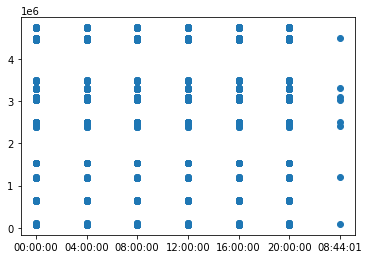

In [21]:
# ignore
plt.scatter(x=flatiron['TIME'], y=(flatiron['EXITS']).astype(int))

This is not very helpful because times are in four-hour increments. 

To verify, let's sample the data and look at the TIME column: 16, 12, 0, 8, etc.

In [22]:
flatiron.sample(200)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,Datetime,Traffic_running_total
211032,A031,R083,00-00-00,23 ST,NRW,BMT,05/04/2019,04:00:00,REGULAR,1196284,644809,2019-05-04 04:00:00,1841093
210887,A030,R083,01-03-01,23 ST,NRW,BMT,05/08/2019,12:00:00,REGULAR,9854576,3027346,2019-05-08 12:00:00,12881922
211187,A031,R083,00-03-00,23 ST,NRW,BMT,05/09/2019,00:00:00,REGULAR,2789820,4750159,2019-05-09 00:00:00,7539979
210995,A030,R083,01-06-01,23 ST,NRW,BMT,05/05/2019,04:00:00,REGULAR,85802620,1188217,2019-05-05 04:00:00,86990837
210795,A030,R083,01-00-02,23 ST,NRW,BMT,05/07/2019,16:00:00,REGULAR,5148310,2402285,2019-05-07 16:00:00,7550595
...,...,...,...,...,...,...,...,...,...,...,...,...,...
211146,A031,R083,00-00-02,23 ST,NRW,BMT,05/09/2019,04:00:00,REGULAR,6517070,3491465,2019-05-09 04:00:00,10008535
4242,A031,R083,00-00-00,23 ST,NRW,BMT,05/02/2019,00:00:00,REGULAR,1190609,641891,2019-05-02 00:00:00,1832500
210718,A030,R083,01-00-00,23 ST,NRW,BMT,05/09/2019,00:00:00,REGULAR,53384,81850,2019-05-09 00:00:00,135234
4188,A030,R083,01-06-01,23 ST,NRW,BMT,04/30/2019,00:00:00,REGULAR,85796042,1184865,2019-04-30 00:00:00,86980907


In [23]:
# ignore
flatiron[flatiron["C/A"]=="A030"].shape

(680, 13)

In [24]:
# ignore
flatiron[flatiron["C/A"]=="A031"].shape

(504, 13)

In [25]:
# ignore
flatiron[flatiron["UNIT"]=="R083"].shape

(1184, 13)

In [26]:
# ignore
252+336

588

In [27]:
# ignore
flatiron[flatiron["UNIT"]=="R083"].tail()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,Datetime,Traffic_running_total
211278,A031,R083,00-03-02,23 ST,NRW,BMT,05/10/2019,04:00:00,REGULAR,81891,103979,2019-05-10 04:00:00,185870
211279,A031,R083,00-03-02,23 ST,NRW,BMT,05/10/2019,08:00:00,REGULAR,81942,104167,2019-05-10 08:00:00,186109
211280,A031,R083,00-03-02,23 ST,NRW,BMT,05/10/2019,12:00:00,REGULAR,82156,104867,2019-05-10 12:00:00,187023
211281,A031,R083,00-03-02,23 ST,NRW,BMT,05/10/2019,16:00:00,REGULAR,82528,105254,2019-05-10 16:00:00,187782
211282,A031,R083,00-03-02,23 ST,NRW,BMT,05/10/2019,20:00:00,REGULAR,83160,105596,2019-05-10 20:00:00,188756


Could do a groupby to aggregate the average or sum of entries at each time of day. 

What about by days of the week?

What about by days of the week?

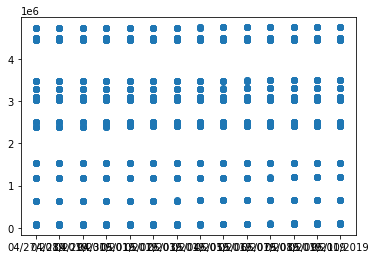

In [28]:
# ignore
plt.scatter(x=flatiron['DATE'], y=(flatiron['EXITS']).astype(int))

I don't think I understand yet what the 'EXITS' column really means yet.  Even within the same week at the same time interval 

there are many datapoints.

To go further, we probably need to review the 'codebook' for this dataset. Otherwise we can end up with a garbage-in analysis

*******
## Update 


I've figured out the issue here. The entries and exits columns are actually cumulative counts for each specific counting device. Therefore to extract the data we need, we need to is the following:
0. Convert ENTRIES and EXITS columns to integers so we can compute their numerical diff
1. Convert it into a list of dataframes where each dataframe in the list corresponds to a counting device. (To do this we first extract the unique values in the device column; then cycle through that list, using each item to extract rows matching it.
2. Then cycle through each data frame in our list of dataframes
    * sort it by TIME just to be on the safe side
    * create two new columns that contains the difference between each row's ENTRY and EXIT counts and that of the previous row
3. Append each of dataframe in the result list into a one list
4. Sort by date and time to find graph these to discover days and times with highest traffic
5. might use a calendar library ot convert date to day of week and do groupby on that
6. could also graph traffic against TIME, while ignorning day
7. Ideally we could drill down and find the day-of-week and time that consistently have the highest traffic during the summer. This would require the above pipeline for multiple weeks and multiple years, and pooling that data.



Unfortunately the "Field description" actually doesn't explain which column corresponds to the counting device. Is it `C/A` or it it `Unit`? 

In [29]:
flatiron.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,Datetime,Traffic_running_total
3876,A030,R083,01-00-00,23 ST,NRW,BMT,04/27/2019,00:00:00,REGULAR,53384,65840,2019-04-27 00:00:00,119224
3877,A030,R083,01-00-00,23 ST,NRW,BMT,04/27/2019,04:00:00,REGULAR,53384,65846,2019-04-27 04:00:00,119230
3878,A030,R083,01-00-00,23 ST,NRW,BMT,04/27/2019,08:00:00,REGULAR,53384,65899,2019-04-27 08:00:00,119283
3879,A030,R083,01-00-00,23 ST,NRW,BMT,04/27/2019,12:00:00,REGULAR,53384,66056,2019-04-27 12:00:00,119440
3880,A030,R083,01-00-00,23 ST,NRW,BMT,04/27/2019,16:00:00,REGULAR,53384,66332,2019-04-27 16:00:00,119716


Let's see how many rows are in a single `C/A` and `UNIT`

In [30]:
flatiron[flatiron["C/A"]=="A030"].shape

(680, 13)

In [31]:
flatiron[flatiron["C/A"]=="A031"].shape

(504, 13)

In [32]:
flatiron[flatiron["UNIT"]=="R083"].shape

(1184, 13)

In [33]:
336+252 == 588

True

Let's look at the seam between `C/A` == A030 and and A031, to see if the cumulative count restarts.

In [34]:
flatiron[flatiron["UNIT"]=="R083"].iloc[330:340]

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,Datetime,Traffic_running_total
4206,A030,R083,01-06-01,23 ST,NRW,BMT,05/03/2019,00:00:00,REGULAR,85800727,1187022,2019-05-03 00:00:00,86987749
4207,A030,R083,01-06-01,23 ST,NRW,BMT,05/03/2019,04:00:00,REGULAR,85800731,1187028,2019-05-03 04:00:00,86987759
4208,A030,R083,01-06-01,23 ST,NRW,BMT,05/03/2019,08:00:00,REGULAR,85800754,1187069,2019-05-03 08:00:00,86987823
4209,A030,R083,01-06-01,23 ST,NRW,BMT,05/03/2019,12:00:00,REGULAR,85800948,1187349,2019-05-03 12:00:00,86988297
4210,A030,R083,01-06-01,23 ST,NRW,BMT,05/03/2019,16:00:00,REGULAR,85801293,1187522,2019-05-03 16:00:00,86988815
4211,A030,R083,01-06-01,23 ST,NRW,BMT,05/03/2019,20:00:00,REGULAR,85801938,1187690,2019-05-03 20:00:00,86989628
4212,A031,R083,00-00-00,23 ST,NRW,BMT,04/27/2019,00:00:00,REGULAR,1179235,636328,2019-04-27 00:00:00,1815563
4213,A031,R083,00-00-00,23 ST,NRW,BMT,04/27/2019,04:00:00,REGULAR,1179322,636343,2019-04-27 04:00:00,1815665
4214,A031,R083,00-00-00,23 ST,NRW,BMT,04/27/2019,08:00:00,REGULAR,1179341,636374,2019-04-27 08:00:00,1815715
4215,A031,R083,00-00-00,23 ST,NRW,BMT,04/27/2019,12:00:00,REGULAR,1179547,636507,2019-04-27 12:00:00,1816054


Indeed, the counting in `EXITS` jumps from 1230536 to 714199 at the seam from A030 to A031, so it seems that the C/A column contains the device label.

Looking further, however, what about the SCP colomn? Let's observe what happens to the EXITS column when SCP shifts.

In [35]:
flatiron[flatiron["UNIT"]=="R083"].iloc[375:380]

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,Datetime,Traffic_running_total
4251,A031,R083,00-00-00,23 ST,NRW,BMT,05/03/2019,12:00:00,REGULAR,1193990,644191,2019-05-03 12:00:00,1838181
4252,A031,R083,00-00-00,23 ST,NRW,BMT,05/03/2019,16:00:00,REGULAR,1194616,644476,2019-05-03 16:00:00,1839092
4253,A031,R083,00-00-00,23 ST,NRW,BMT,05/03/2019,20:00:00,REGULAR,1195814,644748,2019-05-03 20:00:00,1840562
4254,A031,R083,00-00-01,23 ST,NRW,BMT,04/27/2019,00:00:00,REGULAR,4560149,1526809,2019-04-27 00:00:00,6086958
4255,A031,R083,00-00-01,23 ST,NRW,BMT,04/27/2019,04:00:00,REGULAR,4560201,1526816,2019-04-27 04:00:00,6087017


Whoops. When SCP changes, the EXITS counts start again. So actually the combination of the C/A and SCP columns seem to 
define a counting stream

#### Try out a graph using the data from just one device

If this pans out, we'll go back and do this data cleaning at an earlier stage so it affects the entire dataset

In [36]:
FI_device_A031zeroSCP = flatiron[ (flatiron["C/A"]=="A031") & (flatiron["SCP"]=="00-00-00")].copy()
FI_device_A031zeroSCP.sort_values(by=["DATE", "TIME"]).head(10)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,Datetime,Traffic_running_total
4212,A031,R083,00-00-00,23 ST,NRW,BMT,04/27/2019,00:00:00,REGULAR,1179235,636328,2019-04-27 00:00:00,1815563
4213,A031,R083,00-00-00,23 ST,NRW,BMT,04/27/2019,04:00:00,REGULAR,1179322,636343,2019-04-27 04:00:00,1815665
4214,A031,R083,00-00-00,23 ST,NRW,BMT,04/27/2019,08:00:00,REGULAR,1179341,636374,2019-04-27 08:00:00,1815715
4215,A031,R083,00-00-00,23 ST,NRW,BMT,04/27/2019,12:00:00,REGULAR,1179547,636507,2019-04-27 12:00:00,1816054
4216,A031,R083,00-00-00,23 ST,NRW,BMT,04/27/2019,16:00:00,REGULAR,1180147,636763,2019-04-27 16:00:00,1816910
4217,A031,R083,00-00-00,23 ST,NRW,BMT,04/27/2019,20:00:00,REGULAR,1180714,636933,2019-04-27 20:00:00,1817647
4218,A031,R083,00-00-00,23 ST,NRW,BMT,04/28/2019,00:00:00,REGULAR,1180990,637037,2019-04-28 00:00:00,1818027
4219,A031,R083,00-00-00,23 ST,NRW,BMT,04/28/2019,04:00:00,REGULAR,1181052,637049,2019-04-28 04:00:00,1818101
4220,A031,R083,00-00-00,23 ST,NRW,BMT,04/28/2019,08:00:00,REGULAR,1181071,637068,2019-04-28 08:00:00,1818139
4221,A031,R083,00-00-00,23 ST,NRW,BMT,04/28/2019,12:00:00,REGULAR,1181225,637170,2019-04-28 12:00:00,1818395


In [37]:
FI_device_A031zeroSCP["Exit diffs"] = FI_device_A031zeroSCP["EXITS"].diff()

In [38]:
FI_device_A031zeroSCP[FI_device_A031zeroSCP["TIME"]=="00:00:00"]

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,Datetime,Traffic_running_total,Exit diffs
4212,A031,R083,00-00-00,23 ST,NRW,BMT,04/27/2019,00:00:00,REGULAR,1179235,636328,2019-04-27,1815563,NaN
4218,A031,R083,00-00-00,23 ST,NRW,BMT,04/28/2019,00:00:00,REGULAR,1180990,637037,2019-04-28,1818027,104.0
4224,A031,R083,00-00-00,23 ST,NRW,BMT,04/29/2019,00:00:00,REGULAR,1182213,637470,2019-04-29,1819683,35.0
4230,A031,R083,00-00-00,23 ST,NRW,BMT,04/30/2019,00:00:00,REGULAR,1184916,638817,2019-04-30,1823733,39.0
4236,A031,R083,00-00-00,23 ST,NRW,BMT,05/01/2019,00:00:00,REGULAR,1187768,640292,2019-05-01,1828060,67.0
4242,A031,R083,00-00-00,23 ST,NRW,BMT,05/02/2019,00:00:00,REGULAR,1190609,641891,2019-05-02,1832500,54.0
4248,A031,R083,00-00-00,23 ST,NRW,BMT,05/03/2019,00:00:00,REGULAR,1193565,643427,2019-05-03,1836992,52.0
211031,A031,R083,00-00-00,23 ST,NRW,BMT,05/04/2019,00:00:00,REGULAR,1196196,644794,2019-05-04,1840990,46.0
211037,A031,R083,00-00-00,23 ST,NRW,BMT,05/05/2019,00:00:00,REGULAR,1197792,645430,2019-05-05,1843222,68.0
211043,A031,R083,00-00-00,23 ST,NRW,BMT,05/06/2019,00:00:00,REGULAR,1198821,645861,2019-05-06,1844682,38.0


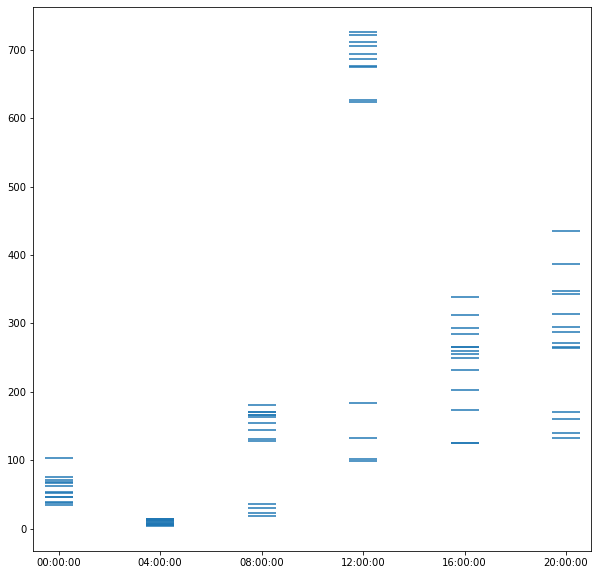

In [39]:
plt.figure(figsize=(10,10))
plt.scatter( x=FI_device_A031zeroSCP['TIME'], y=FI_device_A031zeroSCP['Exit diffs'], marker='_', s=(800,))

#### It seems as though **_8am-12 noon_** time (at least on certain days) as well as **_4pm-8pm_** are the times with the most traffic.

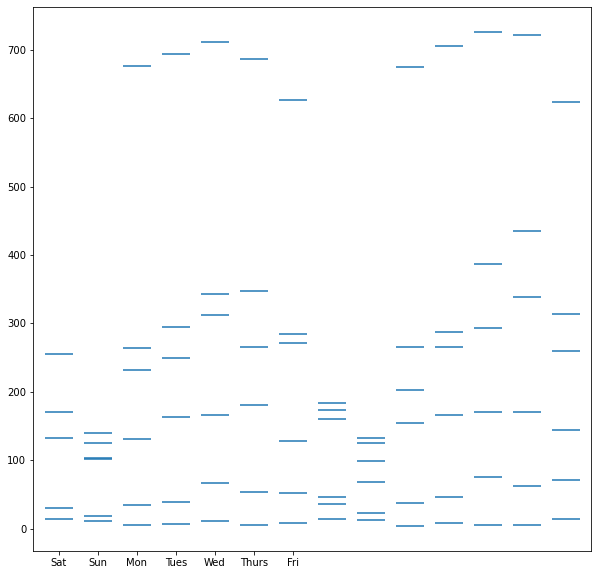

In [40]:
x_labels = ['Sat', 'Sun', 'Mon', 'Tues', 'Wed', 'Thurs', 'Fri'] 
plt.figure(figsize=(10,10))
positions = range(7)
plt.xticks(positions, x_labels)
plt.scatter( x=FI_device_A031zeroSCP['DATE'], y=FI_device_A031zeroSCP['Exit diffs'], marker='_', s=(800,))

#### It seems as though Wednesday and Thursday have the most traffic.

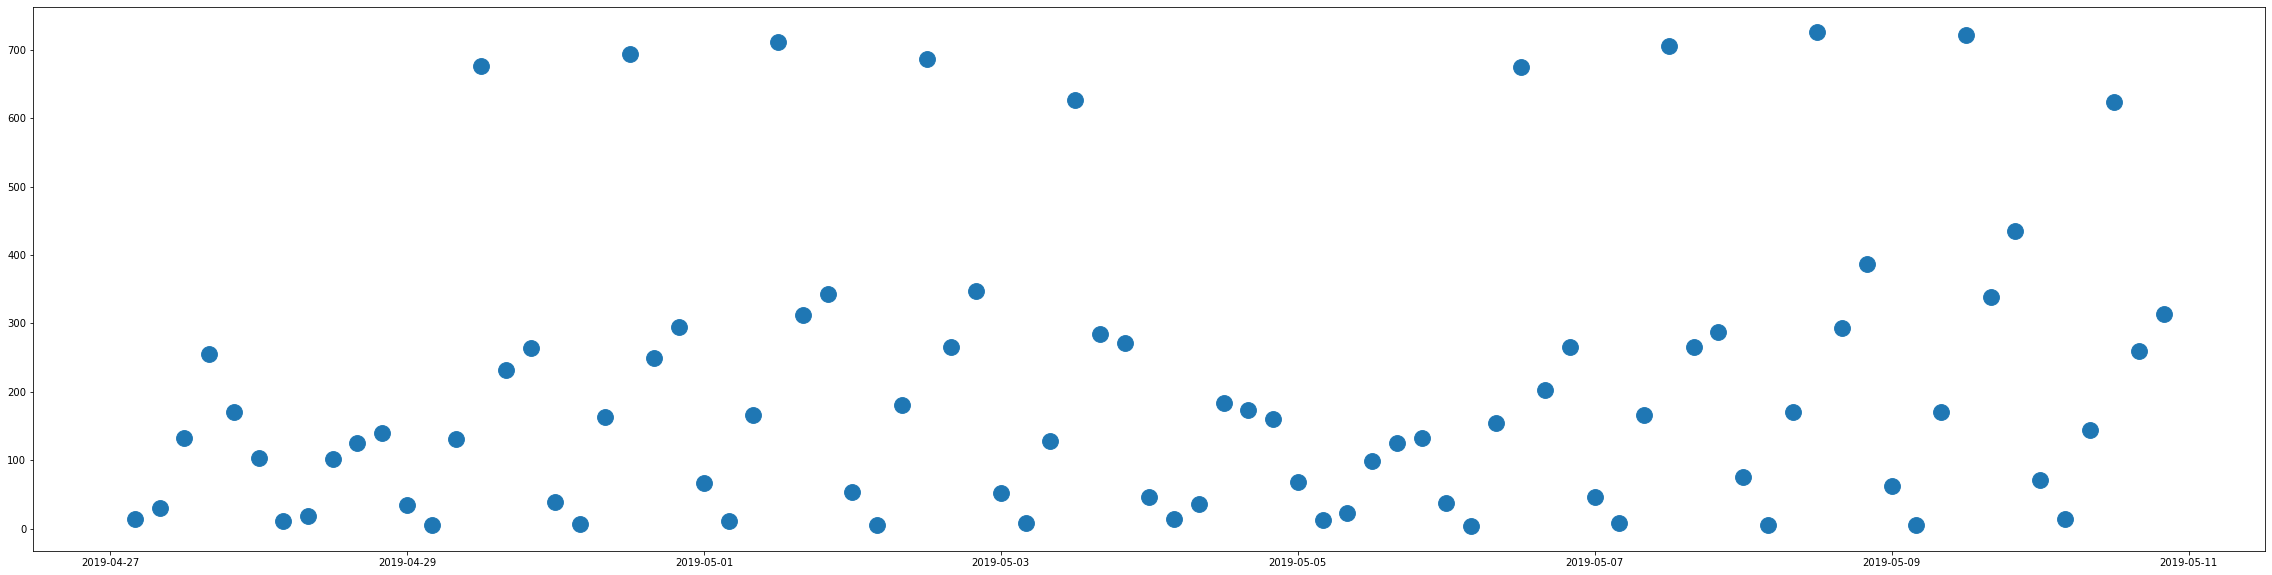

In [41]:
#x_labels = ['Midnight', 'Dawn', 'Morning', 'Afternoon', 'Dusk', 'Evening', 'Night'] 

#fig, ax = plt.subplots()
#fig.figsize=(40,10)
plt.figure(figsize=(40,10))
#positions = range(7*6)
#plt.xticks(positions, x_labels)
#plt.xaxis.set_major_locator(MultipleLocator(20))
plt.scatter( x=FI_device_A031zeroSCP['Datetime'], y=FI_device_A031zeroSCP['Exit diffs'], marker='.', s=(1000,))
#ax.plot( x=FI_device_A031zeroSCP['Datetime'], y=FI_device_A031zeroSCP['Exit diffs'], marker='.', s=(300,))

Attempts to format the x-axis labels with the days of the week have not progressed very far.

In [42]:
# #plt.figure(figsize=(40,10))
# graph = pd.Series(FI_device_A031zeroSCP['Datetime'], FI_device_A031zeroSCP['Exit diffs'])
# ax = graph.plot()
# weekday_map= {0:'MON', 1:'TUE', 2:'WED', 3:'THU',
#               4:'FRI', 5:'SAT', 6:'SUN'}
# xs = sorted(ax.get_xticks(minor='both'))
# wd = graph.index[xs - xs[0]].map(pd.Timestamp.weekday)

# ax.set_xticks(xs)
# ax.set_xticks([], minor=True)
# ax.set_xticklabels([weekday_map[d] for d in wd])
# #plt.scatter( x=FI_device_A031zeroSCP['Datetime'], y=FI_device_A031zeroSCP['Exit diffs'], marker='.', s=(1000,))

In [43]:
time_series = FI_device_A031zeroSCP.set_index('Datetime')['Exit diffs']

In [44]:
import seaborn as sns
import matplotlib.dates as mdates
sns.set(rc={'figure.figsize':(40, 10)})

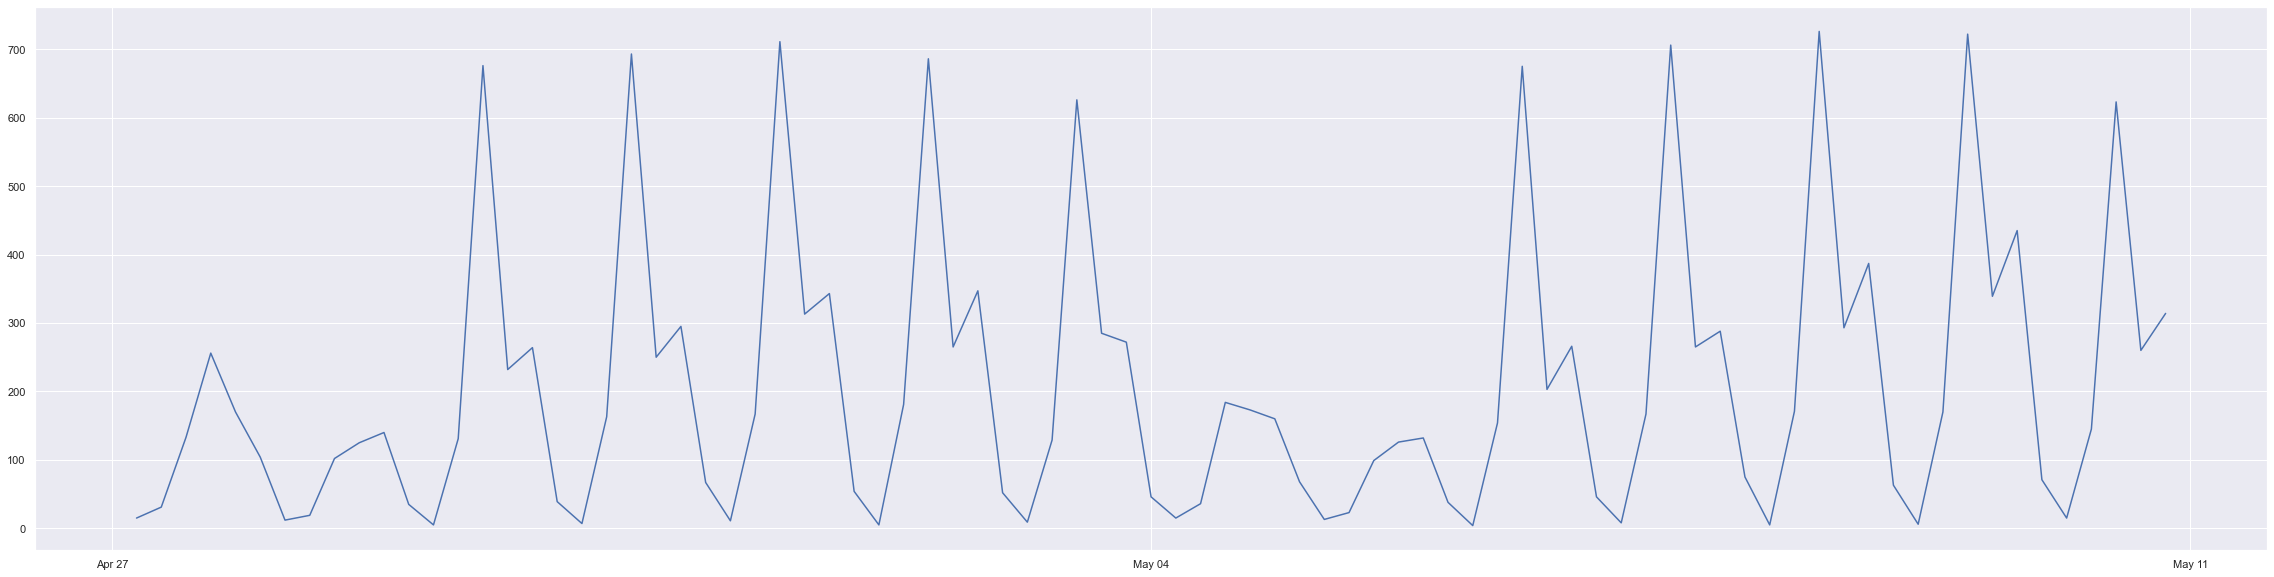

In [45]:
fig, ax = plt.subplots()
ax.plot(time_series)
# Set x-axis major ticks to weekly interval, on Mondays
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.SATURDAY))
# Format x-tick labels as 3-letter month name and day number
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'));

******

Meanwhile, what about the zip code of stations? We'll need to merge this with the turnstile data if we want to 

identify stops that that are higher-income neighborhoods, by joining (merging) with a demographics/census dataset

In [46]:
stations = pd.read_csv('http://web.mta.info/developers/data/nyct/subway/Stations.csv')

In [47]:
stations.sample(10)

,Station ID,Complex ID,GTFS Stop ID,Division,Line,Stop Name,Borough,Daytime Routes,Structure,GTFS Latitude,GTFS Longitude,North Direction Label,South Direction Label,ADA,ADA Notes
88,89,89,J22,BMT,Jamaica,Cleveland St,Bk,J,Elevated,40.679947,-73.884639,Jamaica,Manhattan,0,NaN
198,198,198,H03,IND,Rockaway,Howard Beach-JFK Airport,Q,A,At Grade,40.660476,-73.830301,Manhattan,Rockaways,1,NaN
394,394,394,623,IRT,Lexington Av,110 St,M,6,Subway,40.795020,-73.944250,Uptown & The Bronx,Downtown,0,NaN
438,438,438,224,IRT,Lenox - White Plains Rd,135 St,M,2 3,Subway,40.814229,-73.940770,Uptown & The Bronx,Downtown & Brooklyn,1,NaN
352,352,352,257,IRT,Eastern Pky,New Lots Av,Bk,3,Elevated,40.666235,-73.884079,Manhattan,NaN,0,NaN
455,455,455,711,IRT,Flushing,69 St,Q,7,Elevated,40.746325,-73.896403,Flushing,Manhattan,0,NaN
370,370,370,612,IRT,Pelham,Whitlock Av,Bx,6,Elevated,40.826525,-73.886283,Pelham Bay Park,Manhattan,0,NaN
399,399,399,628,IRT,Lexington Av,68 St-Hunter College,M,6,Subway,40.768141,-73.963870,Uptown & The Bronx,Downtown,0,NaN
135,136,136,L27,BMT,Canarsie,New Lots Av,Bk,L,Elevated,40.658733,-73.899232,Manhattan,Canarsie - Rockaway Parkway,0,NaN
336,336,336,233,IRT,Eastern Pky,Hoyt St,Bk,2 3,Subway,40.690545,-73.985065,Manhattan,Flatbush - New Lots,0,NaN


Whereas the stop names in the turnstile dataset were all caps, these are in title case. 

Who knows if truly corresponding names are used for each station?

As a preliminary step to finding out, lets convert that columns to upper 

In [48]:
stations['Stop Name'] = stations['Stop Name'].str.upper() 

In [49]:
# sanity check
stations.sample(5)

,Station ID,Complex ID,GTFS Stop ID,Division,Line,Stop Name,Borough,Daytime Routes,Structure,GTFS Latitude,GTFS Longitude,North Direction Label,South Direction Label,ADA,ADA Notes
459,459,459,715,IRT,Flushing,40 ST-LOWERY ST,Q,7,Elevated,40.743781,-73.924016,Flushing,Manhattan,0,NaN
209,209,209,H11,IND,Rockaway,FAR ROCKAWAY-MOTT AV,Q,A,Viaduct,40.603995,-73.755405,Manhattan,NaN,1,NaN
430,430,430,217,IRT,Lenox - White Plains Rd,SIMPSON ST,Bx,2 5,Elevated,40.824073,-73.893064,Wakefield - Eastchester,Manhattan,1,NaN
66,67,67,B20,BMT,West End,20 AV,Bk,D,Elevated,40.604556,-73.998168,Manhattan,Coney Island,0,NaN
165,166,618,A31,IND,8th Av - Fulton St,14 ST,M,A C E,Subway,40.740893,-74.001690,Uptown - Queens,Downtown & Brooklyn,1,NaN


In [50]:
stations.columns

Index(['Station ID', 'Complex ID', 'GTFS Stop ID', 'Division', 'Line',
       'Stop Name', 'Borough', 'Daytime Routes', 'Structure', 'GTFS Latitude',
       'GTFS Longitude', 'North Direction Label', 'South Direction Label',
       'ADA', 'ADA Notes'],
      dtype='object')

In [51]:
stations.shape

(496, 15)

## -------- CC - Adding Income Data to Stations by Lat/Lng --------
1. import uszipcode package
2. use lat/lng function to pull median hh income from database

#### Other potentially useful variables from the zipcode list:
zipcode_type='Standard', <br>
major_city='Derwood', <br>
county='Montgomery County', <br>
state='MD', <br>
radius_in_miles=4.0, <br>
population=14295, <br>
population_density=1090.0, <br>
housing_units=5018, <br>
occupied_housing_units=4889,  <br>
median_home_value=453900, <br>
median_household_income=120603

#### Other interesting metrics from this data can be found here: https://pypi.org/project/uszipcode/

In [52]:
### uszip method
from uszipcode import SearchEngine
search = SearchEngine(simple_zipcode=False)

In [53]:
def getincome(_lat,_lon):
    income = search.by_coordinates(_lat,_lon, radius=2,returns=1)[0].median_household_income
    return income

In [54]:
stations['income'] = stations.apply(lambda row:  getincome(row['GTFS Latitude'], row['GTFS Longitude']) ,axis=1)                                              

In [55]:
stations.shape

(496, 16)

In [56]:
# check if income is in df
stations.head()

,Station ID,Complex ID,GTFS Stop ID,Division,Line,Stop Name,Borough,Daytime Routes,Structure,GTFS Latitude,GTFS Longitude,North Direction Label,South Direction Label,ADA,ADA Notes,income
0,1,1,R01,BMT,Astoria,ASTORIA-DITMARS BLVD,Q,N W,Elevated,40.775036,-73.912034,NaN,Manhattan,0,NaN,57525.0
1,2,2,R03,BMT,Astoria,ASTORIA BLVD,Q,N W,Elevated,40.770258,-73.917843,Ditmars Blvd,Manhattan,1,NaN,49924.0
2,3,3,R04,BMT,Astoria,30 AV,Q,N W,Elevated,40.766779,-73.921479,Astoria - Ditmars Blvd,Manhattan,0,NaN,49924.0
3,4,4,R05,BMT,Astoria,BROADWAY,Q,N W,Elevated,40.761820,-73.925508,Astoria - Ditmars Blvd,Manhattan,0,NaN,49924.0
4,5,5,R06,BMT,Astoria,36 AV,Q,N W,Elevated,40.756804,-73.929575,Astoria - Ditmars Blvd,Manhattan,0,NaN,48720.0


In [57]:
print(" \nCount total NaN at each column in a Station : \n\n", stations.isnull().sum(), "# row/cols",stations.shape)

 
Count total NaN at each column in a Station : 

 Station ID                 0
Complex ID                 0
GTFS Stop ID               0
Division                   0
Line                       0
Stop Name                  0
Borough                    0
Daytime Routes             0
Structure                  0
GTFS Latitude              0
GTFS Longitude             0
North Direction Label     18
South Direction Label     15
ADA                        0
ADA Notes                487
income                    31
dtype: int64 # row/cols (496, 16)


In [58]:
print(stations[stations['income'].isna()]) 

     Station ID  Complex ID GTFS Stop ID Division                 Line  \
7             8           8          R13      BMT              Astoria   
8             9           9          R14      BMT  Broadway - Brighton   
9            10          10          R15      BMT  Broadway - Brighton   
10           11         611          R16      BMT  Broadway - Brighton   
17           18         623          R23      BMT             Broadway   
18           19         623          Q01      BMT     Manhattan Bridge   
20           21         624          R25      BMT             Broadway   
103         104         623          M20      BMT              Jamaica   
104         105         622          M21      BMT              Jamaica   
105         106         628          M22      BMT              Jamaica   
106         107         107          M23      BMT              Jamaica   
163         164         164          A28      IND   8th Av - Fulton St   
172         172         628          A

In [59]:
lat=40.764811 
lon=-73.973347

result = search.by_coordinates(lat=lat,lng=lon, radius=5,returns=1)[0].median_household_income    

### We may have to either impute these values separately with the income from the nearest station (i.e. widen the radius)

## --------- CC - END OF INCOME MERGE ----------

## --------- CC - Read in xwalk for booth to stations data ---------
(downloaded from: https://qri.cloud/nyc-transit-data/remote_complex_lookupcsv)

There is no direct link between the stations df and the turnstile df. Therefore we found a link using complex_id from stations and complex_id from xwalk. The xwalk contains C/A, Unit, Station, Line to merge with the turnstile data

You need to have the .csv file saved in the location of the program

In [60]:
station_xwalk = pd.read_csv('booth_station_xwalk.csv')

In [61]:
station_xwalk.head()

,remote,booth,complex_id,station,line_name,division
0,R001,A060,635.0,WHITEHALL ST,R1,BMT
1,R001,A058,635.0,WHITEHALL ST,R1,BMT
2,R001,R101S,635.0,SOUTH FERRY,R1,IRT
3,R002,A077,628.0,FULTON ST,ACJZ2345,BMT
4,R002,A081,628.0,FULTON ST,ACJZ2345,BMT


In [62]:
# complex id is float64 but needs to convert to int. Can only do by filling the nans with 0 first
import numpy as np
station_xwalk['complex_id2'] = station_xwalk['complex_id'].fillna(0,inplace=True)
station_xwalk['complex_id2'] = station_xwalk['complex_id'].apply(np.int64)

In [63]:
station_xwalk.head()

,remote,booth,complex_id,station,line_name,division,complex_id2
0,R001,A060,635.0,WHITEHALL ST,R1,BMT,635
1,R001,A058,635.0,WHITEHALL ST,R1,BMT,635
2,R001,R101S,635.0,SOUTH FERRY,R1,IRT,635
3,R002,A077,628.0,FULTON ST,ACJZ2345,BMT,628
4,R002,A081,628.0,FULTON ST,ACJZ2345,BMT,628


In [64]:
# merge xwalk to stations by complex id
stations_complex = stations.merge(station_xwalk[["remote","booth","station","complex_id2"]], left_on="Complex ID", right_on="complex_id2")

In [65]:
stations_complex.shape

(1011, 20)

In [66]:
test=stations_complex["complex_id2"]==635
test1=stations_complex[test]

In [67]:
test1.head(20)

,Station ID,Complex ID,GTFS Stop ID,Division,Line,Stop Name,Borough,Daytime Routes,Structure,GTFS Latitude,GTFS Longitude,North Direction Label,South Direction Label,ADA,ADA Notes,income,remote,booth,station,complex_id2
193,23,635,R27,BMT,Broadway,WHITEHALL ST-SOUTH FERRY,M,R W,Subway,40.703087,-74.012994,Uptown & Queens,Brooklyn,0,NaN,119274.0,R001,A060,WHITEHALL ST,635
194,23,635,R27,BMT,Broadway,WHITEHALL ST-SOUTH FERRY,M,R W,Subway,40.703087,-74.012994,Uptown & Queens,Brooklyn,0,NaN,119274.0,R001,A058,WHITEHALL ST,635
195,23,635,R27,BMT,Broadway,WHITEHALL ST-SOUTH FERRY,M,R W,Subway,40.703087,-74.012994,Uptown & Queens,Brooklyn,0,NaN,119274.0,R001,R101S,SOUTH FERRY,635
196,330,635,142,IRT,Broadway - 7Av,SOUTH FERRY,M,1,Subway,40.702068,-74.013664,Uptown & The Bronx,NaN,1,NaN,129313.0,R001,A060,WHITEHALL ST,635
197,330,635,142,IRT,Broadway - 7Av,SOUTH FERRY,M,1,Subway,40.702068,-74.013664,Uptown & The Bronx,NaN,1,NaN,129313.0,R001,A058,WHITEHALL ST,635
198,330,635,142,IRT,Broadway - 7Av,SOUTH FERRY,M,1,Subway,40.702068,-74.013664,Uptown & The Bronx,NaN,1,NaN,129313.0,R001,R101S,SOUTH FERRY,635


In [68]:
stations_complex.columns

Index(['Station ID', 'Complex ID', 'GTFS Stop ID', 'Division', 'Line',
       'Stop Name', 'Borough', 'Daytime Routes', 'Structure', 'GTFS Latitude',
       'GTFS Longitude', 'North Direction Label', 'South Direction Label',
       'ADA', 'ADA Notes', 'income', 'remote', 'booth', 'station',
       'complex_id2'],
      dtype='object')

In [69]:
# get unique level stations/ complex data by REMOTE field which will merge back to Turnstile
#stations_complex_inc = stations_complex.groupby(['remote'])['income'].mean().reset_index()

In [70]:
# get unique level stations/ complex data by REMOTE field which will merge back to Turnstile

#stations_complex2 = stations_complex.groupby(['remote']).agg({'income':'mean'}).reset_index()
#stations_complex2 = stations_complex.groupby(['remote'])['income','GTFS Latitude','GTFS Longitude'].agg(['mean']).reset_index()
stations_complex2 = stations_complex.groupby(['remote'])[['income','GTFS Latitude','GTFS Longitude']].agg('mean').reset_index()

In [71]:
stations_complex2.columns

Index(['remote', 'income', 'GTFS Latitude', 'GTFS Longitude'], dtype='object')

In [72]:
stations_complex2.shape

(455, 4)

In [73]:
stations_complex2.head()

,remote,income,GTFS Latitude,GTFS Longitude
0,R001,124293.5,40.702577,-74.013329
1,R002,66074.0,40.710089,-74.007838
2,R003,60897.0,40.689941,-73.872550
3,R004,60897.0,40.691324,-73.867139
4,R005,60897.0,40.692435,-73.860010


In [74]:
print("turnstile shape:",turnstiles_4hourly.shape,"stations shape:",stations_complex2.shape)

turnstile shape: (410945, 15) stations shape: (455, 4)


In [75]:
# merge stations to turnstile df
# !! do NOT merge by station field - we can probably drop the one from turnstile
# we might want to add the DIVISION var back for merging

turnstiles_4hourly_w_station_info = pd.merge(turnstiles_4hourly, stations_complex2,  how='left', left_on=['UNIT'], right_on = ['remote'])

In [76]:
# merge stations to turnstile df
# !! do NOT merge by station field - we can probably drop the one from turnstile
# we might want to add the DIVISION var back for merging

# turnstiles_4hourly_w_station_info = pd.merge(turnstiles_4hourly, stations_complex,  how='left', left_on=['C/A','UNIT'], right_on = ['booth','remote'])

In [77]:
print("turnstile shape:",turnstiles_4hourly.shape,"turnstile station shape:",turnstiles_4hourly_w_station_info.shape)

turnstile shape: (410945, 15) turnstile station shape: (410945, 19)


In [78]:
turnstiles_4hourly_w_station_info.head()

,C/A,UNIT,SCP,STATION,LINENAME,Datetime,Traffic_running_total,PREV_TIME,PREV_Traffic_running_total,Hour,Delta_hours,People_per_hour,Day_num,Day_of_week,Day_hour,remote,income,GTFS Latitude,GTFS Longitude
0,A002,R051,02-00-00,59 ST,NQR456W,2019-04-27 00:00:00,9420082,NaT,NaN,0,NaN,NaN,5,Saturday,5.000000,R051,112269.0,40.762593,-73.967612
1,A002,R051,02-00-00,59 ST,NQR456W,2019-04-27 04:00:00,9420109,2019-04-27 00:00:00,9420082.0,4,4.0,6.75,5,Saturday,5.166667,R051,112269.0,40.762593,-73.967612
2,A002,R051,02-00-00,59 ST,NQR456W,2019-04-27 08:00:00,9420167,2019-04-27 04:00:00,9420109.0,8,4.0,14.50,5,Saturday,5.333333,R051,112269.0,40.762593,-73.967612
3,A002,R051,02-00-00,59 ST,NQR456W,2019-04-27 12:00:00,9420343,2019-04-27 08:00:00,9420167.0,12,4.0,44.00,5,Saturday,5.500000,R051,112269.0,40.762593,-73.967612
4,A002,R051,02-00-00,59 ST,NQR456W,2019-04-27 16:00:00,9420671,2019-04-27 12:00:00,9420343.0,16,4.0,82.00,5,Saturday,5.666667,R051,112269.0,40.762593,-73.967612


In [79]:
# Remove outliers of turnstile per hour > 10000
turnstiles_4hourly_w_station_info_cleaner = turnstiles_4hourly_w_station_info[ (turnstiles_4hourly_w_station_info["People_per_hour"] >0) & (turnstiles_4hourly_w_station_info["People_per_hour"] < 10000)]

In [80]:
turnstiles_4hourly_w_station_info_cleaner.columns


Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'Datetime',
       'Traffic_running_total', 'PREV_TIME', 'PREV_Traffic_running_total',
       'Hour', 'Delta_hours', 'People_per_hour', 'Day_num', 'Day_of_week',
       'Day_hour', 'remote', 'income', 'GTFS Latitude', 'GTFS Longitude'],
      dtype='object')

In [81]:
turnstiles_4hourly_w_station_info_cleaner.head()

,C/A,UNIT,SCP,STATION,LINENAME,Datetime,Traffic_running_total,PREV_TIME,PREV_Traffic_running_total,Hour,Delta_hours,People_per_hour,Day_num,Day_of_week,Day_hour,remote,income,GTFS Latitude,GTFS Longitude
1,A002,R051,02-00-00,59 ST,NQR456W,2019-04-27 04:00:00,9420109,2019-04-27 00:00:00,9420082.0,4,4.0,6.75,5,Saturday,5.166667,R051,112269.0,40.762593,-73.967612
2,A002,R051,02-00-00,59 ST,NQR456W,2019-04-27 08:00:00,9420167,2019-04-27 04:00:00,9420109.0,8,4.0,14.50,5,Saturday,5.333333,R051,112269.0,40.762593,-73.967612
3,A002,R051,02-00-00,59 ST,NQR456W,2019-04-27 12:00:00,9420343,2019-04-27 08:00:00,9420167.0,12,4.0,44.00,5,Saturday,5.500000,R051,112269.0,40.762593,-73.967612
4,A002,R051,02-00-00,59 ST,NQR456W,2019-04-27 16:00:00,9420671,2019-04-27 12:00:00,9420343.0,16,4.0,82.00,5,Saturday,5.666667,R051,112269.0,40.762593,-73.967612
5,A002,R051,02-00-00,59 ST,NQR456W,2019-04-27 20:00:00,9421000,2019-04-27 16:00:00,9420671.0,20,4.0,82.25,5,Saturday,5.833333,R051,112269.0,40.762593,-73.967612


In [82]:
# Here we can choose which "station" variable to keep. right now it's from turnstile
turnstile_station = turnstiles_4hourly_w_station_info_cleaner[["STATION", "LINENAME","Datetime", "Day_of_week", "Day_num", "Hour", "Day_hour","People_per_hour","GTFS Latitude","GTFS Longitude","income"]]

In [83]:
turnstile_station.head()

,STATION,LINENAME,Datetime,Day_of_week,Day_num,Hour,Day_hour,People_per_hour,GTFS Latitude,GTFS Longitude,income
1,59 ST,NQR456W,2019-04-27 04:00:00,Saturday,5,4,5.166667,6.75,40.762593,-73.967612,112269.0
2,59 ST,NQR456W,2019-04-27 08:00:00,Saturday,5,8,5.333333,14.50,40.762593,-73.967612,112269.0
3,59 ST,NQR456W,2019-04-27 12:00:00,Saturday,5,12,5.500000,44.00,40.762593,-73.967612,112269.0
4,59 ST,NQR456W,2019-04-27 16:00:00,Saturday,5,16,5.666667,82.00,40.762593,-73.967612,112269.0
5,59 ST,NQR456W,2019-04-27 20:00:00,Saturday,5,20,5.833333,82.25,40.762593,-73.967612,112269.0


In [84]:
# Commenting out hte original merge below which i don't think would've worked

In [85]:
# Back to turnstile df, merge Station (with income) and keep rows with ppl per hour between 0-10000
# turnstiles_4hourly_w_station_info = turnstiles_4hourly.merge(stations_complex, left_on="STATION", right_on="Stop Name")
# turnstiles_4hourly_w_station_info_cleaner = turnstiles_4hourly_w_station_info[ (turnstiles_4hourly_w_station_info["People_per_hour"] >0) & (turnstiles_4hourly_w_station_info["People_per_hour"] < 10000)]
# turnstile_summary = turnstiles_4hourly_w_station_info_cleaner[["STATION", "Datetime", "Day_of_week", "Day_num", "Hour", "Day_hour","People_per_hour","GTFS Latitude","GTFS Longitude"]]

## -------- CC - END OF STATIONS/Xwalk/Turnstiles Merge ---------

### Composite of all stations, day-by-day traffic people per hour
(haven't yet made title or labeled y axis--needs to be done)

In [86]:
plt.style.use(['seaborn-bright'])
plt.style.use(['seaborn-white'])
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}

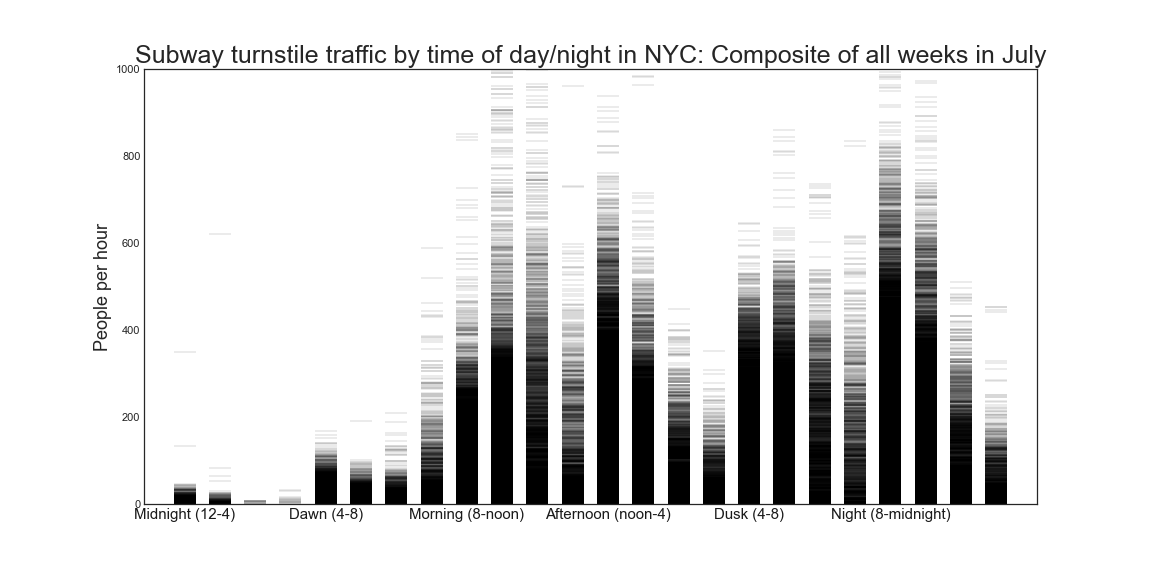

In [87]:
plt.figure(figsize=(16,8))

station_list = list([turnstile_station])

#station_list = turnstile_station['STATION'].unique().tolist()
ticks_x = [0, 4, 8, 12, 16, 20]
time_name = dict({0:'Midnight (12-4)', 4:'Dawn (4-8)', 8: 'Morning (8-noon)', 12: 'Afternoon (noon-4)',16:'Dusk (4-8)',20:'Night (8-midnight)'})
times = [time_name[t] for t in ticks_x]
#times =[0, 4, 8, 12, 16, 20]
plt.xticks(ticks_x, times, fontsize = '15', color='k');


size_ = 500
alpha_ = .1
plt.ylim([0, 1000])

plt.title('Subway turnstile traffic by time of day/night in NYC: Composite of all weeks in July', fontsize='25')
plt.ylabel('People per hour', fontsize='18')

# plt.scatter( x=turnstile_station[turnstile_station['STATION']==station_list[0]]['Day_hour'], y=turnstile_station[turnstile_station['STATION']==station_list[0]]['People_per_hour'], marker='.', s=(size_,), alpha = alpha_)
# plt.scatter( x=turnstile_station[turnstile_station['STATION']==station_list[1]]['Day_hour'], y=turnstile_station[turnstile_station['STATION']==station_list[1]]['People_per_hour'], marker='.', s=(size_,),  alpha = alpha_)
# plt.scatter( x=turnstile_station[turnstile_station['STATION']==station_list[2]]['Day_hour'], y=turnstile_station[turnstile_station['STATION']==station_list[2]]['People_per_hour'], marker='.', s=(size_,),  alpha = alpha_)
# plt.scatter( x=turnstile_station[turnstile_station['STATION']==station_list[3]]['Day_hour'], y=turnstile_station[turnstile_station['STATION']==station_list[3]]['People_per_hour'], marker='.', s=(size_,),  alpha = alpha_)

plt.scatter( x=station_list[0]['Hour'], y=station_list[0]['People_per_hour'], marker='_', s=(size_,), color='black', alpha=alpha_)
# plt.scatter( x=station_list[2]['Day_hour'], y=station_list[2]['People_per_hour'], marker='_', s=(size_,), color='red', alpha=alpha_)
# plt.scatter( x=station_list[1]['Day_hour'], y=station_list[1]['People_per_hour'], marker='_', s=(size_,), color='blue', alpha=alpha_)
# plt.scatter( x=station_list[0]['Day_hour'], y=station_list[0]['People_per_hour'], marker='_', s=(size_,), color='green', alpha=alpha_)

#plt.savefig('Hourly_turnstile_fluctuation_in_NYC.png',transparent=True, bbox_inches='tight')
#plt.savefig('Hourly_turnstile_fluctuation_in_NYC.png',transparent=True, bbox_inches='tight')
plt.savefig('Hourly_turnstile_fluctuation_in_NYC.png',transparent=True, bbox_inches='tight')

In [88]:
stations_avg_by_time = turnstile_station.groupby(['Hour']).agg({'People_per_hour': ['mean']}).reset_index()

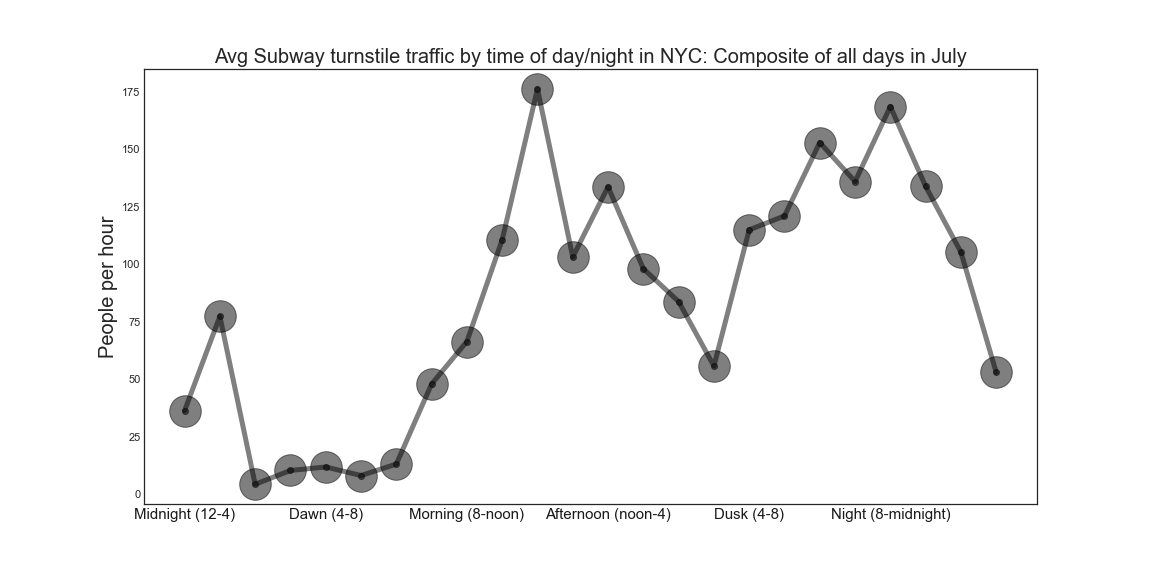

In [89]:

plt.figure(figsize=(16,8))

#station_list = turnstile_station['STATION'].unique().tolist()
station_list = list([stations_avg_by_time]) 
# ticks_x = np.linspace(0.5, 6.5, 6)
ticks_x = [0, 4, 8, 12, 16, 20]
time_name = dict({0:'Midnight (12-4)', 4:'Dawn (4-8)', 8: 'Morning (8-noon)', 12: 'Afternoon (noon-4)',16:'Dusk (4-8)',20:'Night (8-midnight)'})
times = [time_name[t] for t in ticks_x]
#times =[0, 4, 8, 12, 16, 20]
plt.xticks(ticks_x, times, fontsize = '15', color='k');
size_ = 1000
alpha_ = .5

plt.title('Avg Subway turnstile traffic by time of day/night in NYC: Composite of all days in July', fontsize='20')
plt.ylabel('People per hour', fontsize='20')

#for i in range(len(station_list)):
station=0
plt.scatter( x=station_list[station]['Hour'], y=station_list[station]['People_per_hour'], marker='o', s=(size_,), color='black', alpha=alpha_)
plt.plot( station_list[station]['Hour'], station_list[station]['People_per_hour'], marker='o', color='black', alpha=alpha_, lw='5')

# station=1
# plt.scatter( x=station_list[station]['Hour'], y=station_list[station]['People_per_hour'], marker='o', s=(size_,), color=colors_[station], alpha=alpha_)
# station=2
# plt.scatter( x=station_list[station]['Hour'], y=station_list[station]['People_per_hour'], marker='o', s=(size_,), color=colors_[station], alpha=alpha_)
# station=3
# plt.scatter( x=station_list[station]['Hour'], y=station_list[station]['People_per_hour'], marker='o', s=(size_,), color=colors_[station], alpha=alpha_)

# plt.scatter( x=turnstile_station[turnstile_station['STATION']==station_list[1]]['Hour'], y=turnstile_station[turnstile_station['STATION']==station_list[1]]['People_per_hour'], marker='.', s=(size_,), alpha=alpha_)
# plt.scatter( x=turnstile_station[turnstile_station['STATION']==station_list[2]]['Hour'], y=turnstile_station[turnstile_station['STATION']==station_list[2]]['People_per_hour'], marker='.', s=(size_,), alpha=alpha_)
# plt.scatter( x=turnstile_station[turnstile_station['STATION']==station_list[3]]['Hour'], y=turnstile_station[turnstile_station['STATION']==station_list[3]]['People_per_hour'], marker='.', s=(size_,), alpha=alpha_)

plt.savefig('Avg_Hourly_turnstile_fluctuation_in_NYC.svg',transparent=True)

In [90]:
# station_list = list([turnstile_station])

# plt.figure(figsize=(16,6))

# colors_ = dict({0:'green', 1:'blue', 2: 'red', 3: 'orange'})

# # ticks_x = np.linspace(0.5, 6.5, 6)
# ticks_x = [0, 4, 8, 12, 16, 20]
# time_name = dict({0:'Midnight (12-4)', 4:'Dawn (4-8)', 8: 'Morning (8-noon)', 12: 'Afternoon (noon-4)',16:'Dusk (4-8)',20:'Night (8-midnight)'})
# times = [time_name[t] for t in ticks_x]
# #times =[0, 4, 8, 12, 16, 20]
# plt.xticks(ticks_x, times, fontsize = '15', color='k');
# size_ = 1000
# alpha_ = .1

# plt.title('Subway turnstile traffic in NYC: Composite of all weeks in July', fontsize='25')
# plt.ylabel('People per hour', fontsize='18')

# ticks_x = range(7)
# # days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']
# plt.xticks(ticks_x, times, fontsize = '20', color='k');

# plt.scatter( x=turnstile_station['Day_num'], y=turnstile_station['People_per_hour'], marker='_', s=(300,), alpha=.2, color='black')


# plt.savefig('Daily_turnstile_fluctuation_in_NYC.svg',transparent=True, bbox_inches='tight')

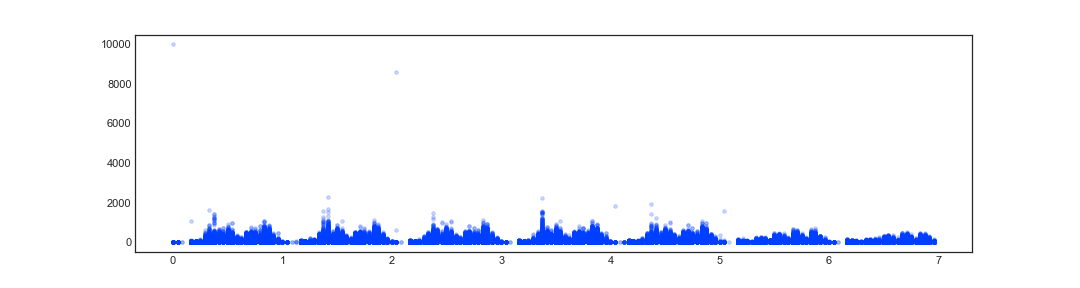

In [176]:
plt.figure(figsize=(15,4))

plt.scatter( x=turnstile_station['Day_hour'], y=turnstile_station['People_per_hour'], marker='.', s=(50,), alpha=.2)


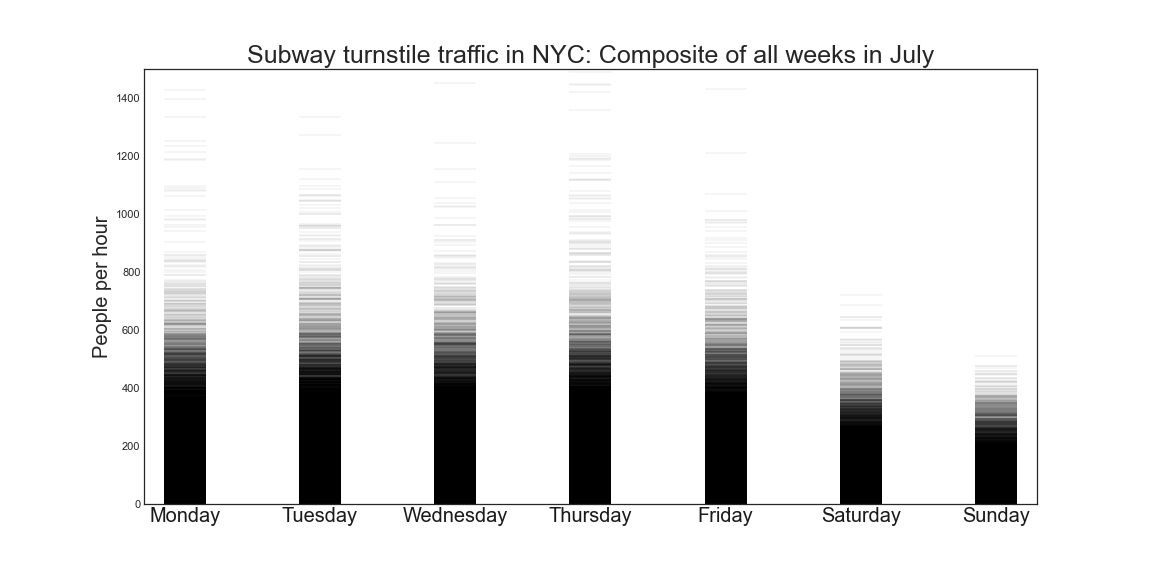

In [92]:
#station_list = turnstile_station['STATION'].unique().tolist()
plt.figure(figsize=(16,8))

station_list = list([turnstile_station])

ticks_x = range(7)
days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']
plt.xticks(ticks_x, days, fontsize = '20', color='k');
size_ = 1800
alpha_ = .05

plt.ylim([0,1500])
plt.title('Subway turnstile traffic in NYC: Composite of all weeks in July', fontsize='25')
plt.ylabel('People per hour', fontsize='20')

neutral='black'
plt.scatter( x=station_list[0]['Day_num'], y=station_list[0]['People_per_hour'], marker='_', s=(size_,), color=neutral, alpha=alpha_)
# plt.scatter( x=station_list[1]['Day_num'], y=station_list[1]['People_per_hour'], marker='_', s=(size_,), color='blue', alpha=alpha_)
# plt.scatter( x=station_list[2]['Day_num'], y=station_list[2]['People_per_hour'], marker='_', s=(size_,), color='red', alpha=alpha_)
# plt.scatter( x=station_list[3]['Day_num'], y=station_list[3]['People_per_hour'], marker='_', s=(size_,), color='orange', alpha=alpha_)



# plt.scatter( x=turnstile_station[turnstile_station['STATION']==station_list[0]]['Day_num'], y=turnstile_station[turnstile_station['STATION']==station_list[0]]['People_per_hour'], marker='.', s=(size_,), alpha=alpha_)
# plt.scatter( x=turnstile_station[turnstile_station['STATION']==station_list[1]]['Day_num'], y=turnstile_station[turnstile_station['STATION']==station_list[1]]['People_per_hour'], marker='.', s=(size_,), alpha=alpha_)
# plt.scatter( x=turnstile_station[turnstile_station['STATION']==station_list[2]]['Day_num'], y=turnstile_station[turnstile_station['STATION']==station_list[2]]['People_per_hour'], marker='.', s=(size_,), alpha=alpha_)
# plt.scatter( x=turnstile_station[turnstile_station['STATION']==station_list[3]]['Day_num'], y=turnstile_station[turnstile_station['STATION']==station_list[3]]['People_per_hour'], marker='.', s=(size_,), alpha=alpha_)
plt.savefig('Daily_turnstile_fluctuation_in_NYC.png',transparent=True)

In [93]:
stations_avg_by_day = turnstile_station.groupby(['Day_num']).agg({'People_per_hour': ['mean']}).reset_index()

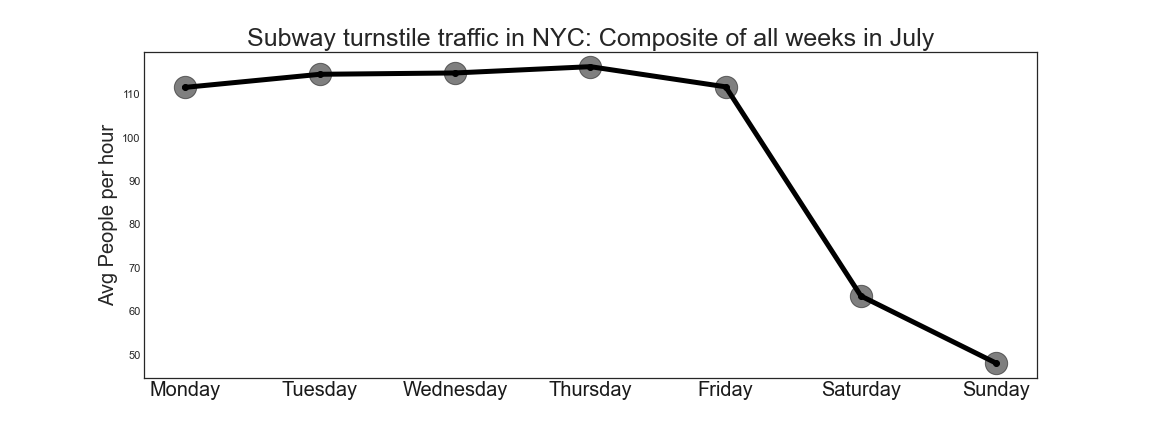

<Figure size 2880x720 with 0 Axes>

In [177]:
plt.figure(figsize=(16,6))


plt.title('Subway turnstile traffic in NYC: Composite of all weeks in July', fontsize='25')
plt.ylabel('Avg People per hour', fontsize='20')
plt.ylim = ([0,140])

ticks_x = range(7)
days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']
plt.xticks(ticks_x, days, fontsize = '20', color='k');

alpha_=.5
#plt.scatter( x=stations_avg_hourly['Day_num'], y=stations_avg_hourly ['People_per_hour'], marker='o', s=(300,), alpha=1, color='black')

plt.scatter( x=stations_avg_by_day['Day_num'], y=stations_avg_by_day['People_per_hour'], marker='o', s=(size_,), color='black', alpha=alpha_)
plt.plot( stations_avg_by_day['Day_num'], stations_avg_by_day['People_per_hour'], marker='o', alpha=1, color='black', lw=5);
plt.show()

plt.savefig('Avg_Daily_turnstile_fluctuation_in_NYC.svg',transparent=True)

TypeError: 'list' object is not callable

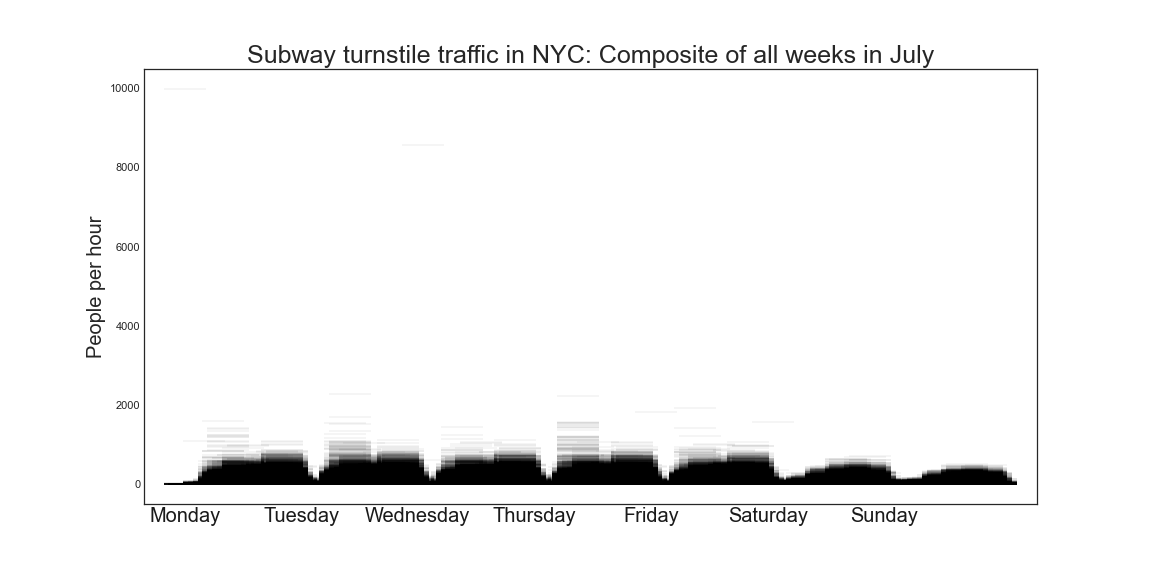

In [181]:
#station_list = turnstile_station['STATION'].unique().tolist()
plt.figure(figsize=(16,8))

station_list = list([turnstile_station])

ticks_x = range(7)
days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']
plt.xticks(ticks_x, days, fontsize = '20', color='k');
size_ = 1800
alpha_ = .05


plt.title('Subway turnstile traffic in NYC: Composite of all weeks in July', fontsize='25')
plt.ylabel('People per hour', fontsize='20')

neutral='black'
plt.scatter( x=station_list[0]['Day_hour'], y=station_list[0]['People_per_hour'], marker='_', s=(size_,), color=neutral, alpha=alpha_)
# plt.scatter( x=station_list[1]['Day_num'], y=station_list[1]['People_per_hour'], marker='_', s=(size_,), color='blue', alpha=alpha_)
# plt.scatter( x=station_list[2]['Day_num'], y=station_list[2]['People_per_hour'], marker='_', s=(size_,), color='red', alpha=alpha_)
# plt.scatter( x=station_list[3]['Day_num'], y=station_list[3]['People_per_hour'], marker='_', s=(size_,), color='orange', alpha=alpha_)
plt.ylim(0,300)


# plt.scatter( x=turnstile_station[turnstile_station['STATION']==station_list[0]]['Day_num'], y=turnstile_station[turnstile_station['STATION']==station_list[0]]['People_per_hour'], marker='.', s=(size_,), alpha=alpha_)
# plt.scatter( x=turnstile_station[turnstile_station['STATION']==station_list[1]]['Day_num'], y=turnstile_station[turnstile_station['STATION']==station_list[1]]['People_per_hour'], marker='.', s=(size_,), alpha=alpha_)
# plt.scatter( x=turnstile_station[turnstile_station['STATION']==station_list[2]]['Day_num'], y=turnstile_station[turnstile_station['STATION']==station_list[2]]['People_per_hour'], marker='.', s=(size_,), alpha=alpha_)
# plt.scatter( x=turnstile_station[turnstile_station['STATION']==station_list[3]]['Day_num'], y=turnstile_station[turnstile_station['STATION']==station_list[3]]['People_per_hour'], marker='.', s=(size_,), alpha=alpha_)
plt.savefig('Daily_turnstile_fluctuation_in_NYC.png',transparent=True)

In [95]:
stations_list = [turnstile_station]
stations_list[0].shape

(297969, 11)

In [96]:
#stations_list_avg_hourly.shape

In [97]:
# plt.figure(figsize=(16,8))
# # stations_avg_by_day = turnstile_station.groupby(['Day_num']).agg({'People_per_hour': ['mean']}).reset_index()
# stations_list = list([stations_avg_hourly]) 

# #station_list = turnstile_station['STATION'].unique().tolist()
# # station_list = flatiron_stations

# colors_ = dict({0:'green', 1:'blue', 2: 'red', 3: 'orange', 4: 'black'})

# # ticks_x = np.linspace(0.5, 6.5, 6)
# ticks_x = [0, 4, 8, 12, 16, 20]
# time_name = dict({0:'Midnight (12-4)', 4:'Dawn (4-8)', 8: 'Morning (8-noon)', 12: 'Afternoon (noon-4)',16:'Dusk (4-8)',20:'Night (8-midnight)'})
# times = [time_name[t] for t in ticks_x]
# #times =[0, 4, 8, 12, 16, 20]
# plt.xticks(ticks_x, times, fontsize = '15', color='k');
# size_ = 100
# alpha_ = 1
# plt.ylim([0, 280])

# plt.title('Subway turnstile traffic by time of day/night in NYC: Composite of all days in July', fontsize='20')
# plt.ylabel('People per hour', fontsize='20')

# #for i in range(len(station_list)):
# plt.scatter( x=station_list[0]['Hour'], y=station_list[0]['People_per_hour'], marker='o', s=(size_,), color=colors_[4], alpha=alpha_)

# plt.savefig('Hourly_turnstile_fluctuation_in_NYC.svg',transparent=True, bbox_inches='tight')

In [98]:
# stations_avg_hourly = turnstile_station.groupby(['Hour']).mean().reset_index()


stations_avg_hourly = turnstile_station.groupby(['Hour']).agg({'People_per_hour': ['mean']}).reset_index()
stations_avg_hourly.head(50)



,Hour,People_per_hour
,,mean
0,0,36.325962
1,1,77.300962
2,2,4.373077
3,3,10.354167
4,4,11.877264
5,5,8.165257
6,6,13.120622
7,7,47.929315
8,8,66.383973


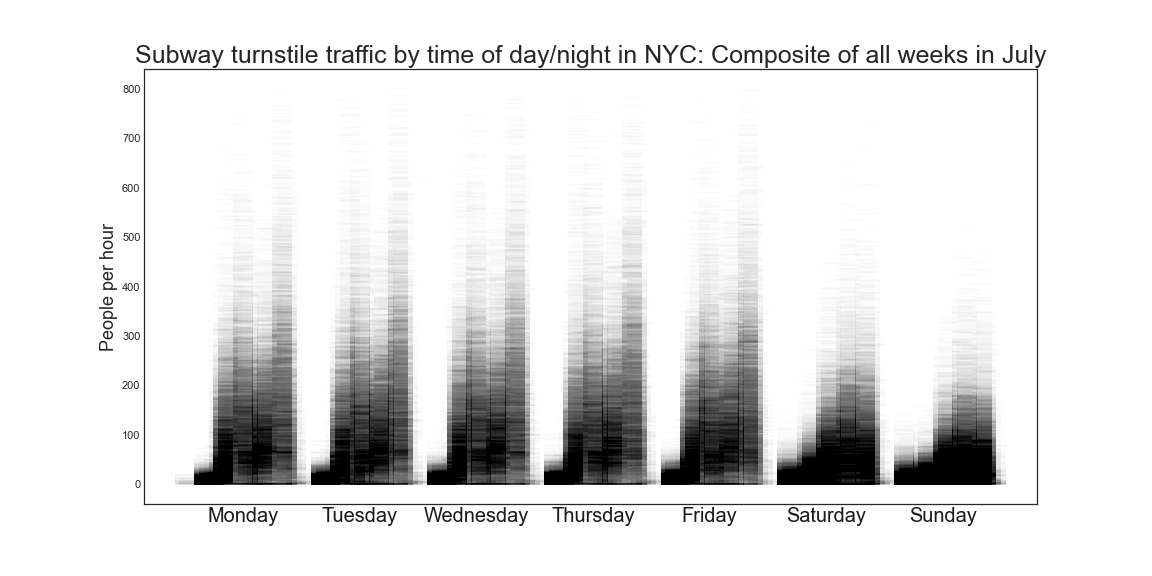

In [194]:
plt.figure(figsize=(16,8))

station_list = list([turnstile_station[turnstile_station["People_per_hour"]<800]])

#station_list = turnstile_station['STATION'].unique().tolist()
ticks_x = np.linspace(0.5, 6.5, 7)
days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']
plt.xticks(ticks_x, days, fontsize = '20', color='k');
size_ = 370
alpha_ = .01



plt.title('Subway turnstile traffic by time of day/night in NYC: Composite of all weeks in July', fontsize='25')
plt.ylabel('People per hour', fontsize='18')

#plt.ylim(0,100)

# plt.scatter( x=turnstile_station[turnstile_station['STATION']==station_list[0]]['Day_hour'], y=turnstile_station[turnstile_station['STATION']==station_list[0]]['People_per_hour'], marker='.', s=(size_,), alpha = alpha_)
# plt.scatter( x=turnstile_station[turnstile_station['STATION']==station_list[1]]['Day_hour'], y=turnstile_station[turnstile_station['STATION']==station_list[1]]['People_per_hour'], marker='.', s=(size_,),  alpha = alpha_)
# plt.scatter( x=turnstile_station[turnstile_station['STATION']==station_list[2]]['Day_hour'], y=turnstile_station[turnstile_station['STATION']==station_list[2]]['People_per_hour'], marker='.', s=(size_,),  alpha = alpha_)
# plt.scatter( x=turnstile_station[turnstile_station['STATION']==station_list[3]]['Day_hour'], y=turnstile_station[turnstile_station['STATION']==station_list[3]]['People_per_hour'], marker='.', s=(size_,),  alpha = alpha_)

plt.scatter( x=station_list[0]['Day_hour'], y=station_list[0]['People_per_hour'], marker='_', s=(size_,), color='black', alpha=alpha_)
# plt.scatter( x=station_list[2]['Day_hour'], y=station_list[2]['People_per_hour'], marker='_', s=(size_,), color='red', alpha=alpha_)
# plt.scatter( x=station_list[1]['Day_hour'], y=station_list[1]['People_per_hour'], marker='_', s=(size_,), color='blue', alpha=alpha_)
# plt.scatter( x=station_list[0]['Day_hour'], y=station_list[0]['People_per_hour'], marker='_', s=(size_,), color='green', alpha=alpha_)

#plt.ylim(0, 1000)

plt.savefig('Day_hourly_turnstile_fluctuation_in_NYC.png',transparent=True, bbox_inches='tight')
plt.show()

TypeError: 'list' object is not callable

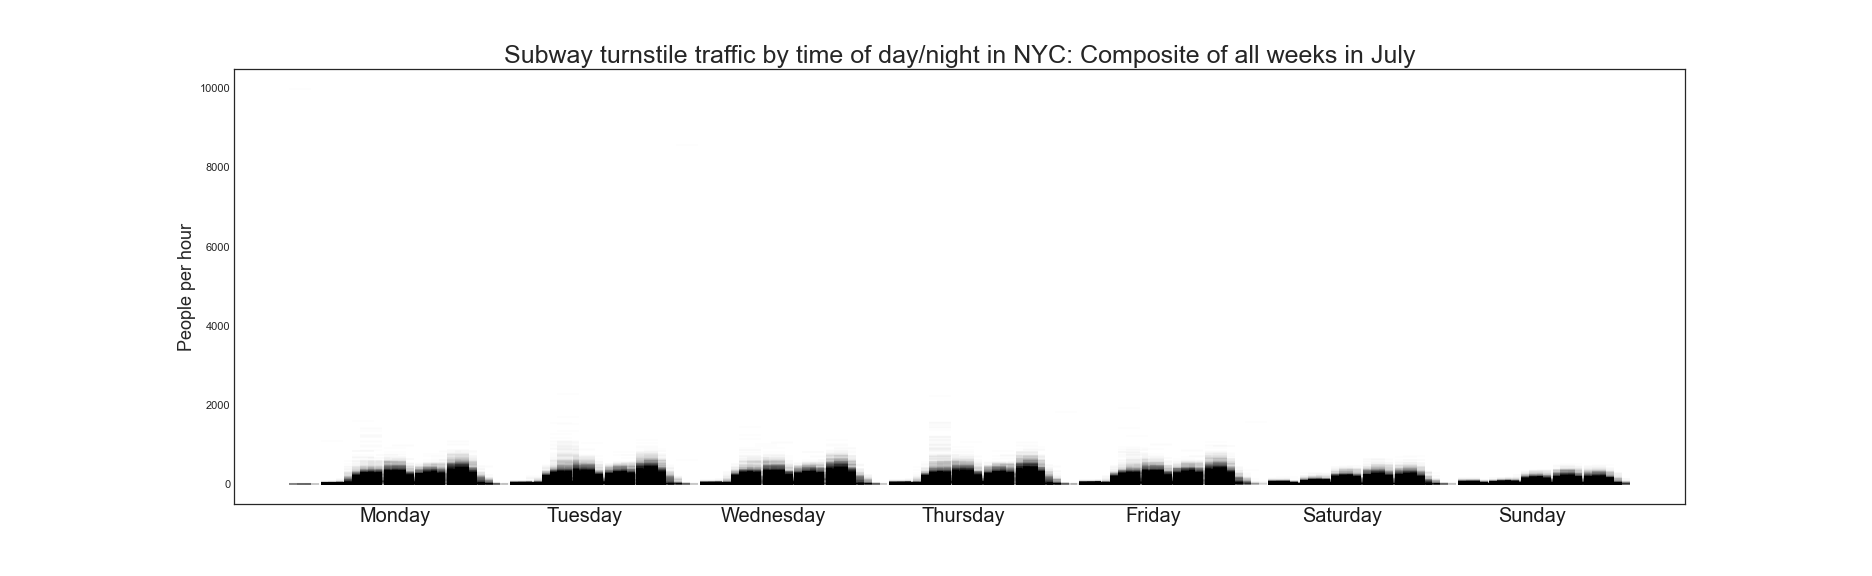

In [175]:
plt.figure(figsize=(26,8))

station_list = list([turnstile_station])

#station_list = turnstile_station['STATION'].unique().tolist()
ticks_x = np.linspace(0.5, 6.5, 7)
days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']
plt.xticks(ticks_x, days, fontsize = '20', color='k');
size_ = 500
alpha_ = .01



plt.title('Subway turnstile traffic by time of day/night in NYC: Composite of all weeks in July', fontsize='25')
plt.ylabel('People per hour', fontsize='18')

#plt.ylim(0,100)

# plt.scatter( x=turnstile_station[turnstile_station['STATION']==station_list[0]]['Day_hour'], y=turnstile_station[turnstile_station['STATION']==station_list[0]]['People_per_hour'], marker='.', s=(size_,), alpha = alpha_)
# plt.scatter( x=turnstile_station[turnstile_station['STATION']==station_list[1]]['Day_hour'], y=turnstile_station[turnstile_station['STATION']==station_list[1]]['People_per_hour'], marker='.', s=(size_,),  alpha = alpha_)
# plt.scatter( x=turnstile_station[turnstile_station['STATION']==station_list[2]]['Day_hour'], y=turnstile_station[turnstile_station['STATION']==station_list[2]]['People_per_hour'], marker='.', s=(size_,),  alpha = alpha_)
# plt.scatter( x=turnstile_station[turnstile_station['STATION']==station_list[3]]['Day_hour'], y=turnstile_station[turnstile_station['STATION']==station_list[3]]['People_per_hour'], marker='.', s=(size_,),  alpha = alpha_)

plt.scatter( x=turnstile_station['Day_hour'], y=turnstile_station['People_per_hour'], marker='_', s=(size_,), color='black', alpha=alpha_)
# plt.scatter( x=station_list[2]['Day_hour'], y=station_list[2]['People_per_hour'], marker='_', s=(size_,), color='red', alpha=alpha_)
# plt.scatter( x=station_list[1]['Day_hour'], y=station_list[1]['People_per_hour'], marker='_', s=(size_,), color='blue', alpha=alpha_)
# plt.scatter( x=station_list[0]['Day_hour'], y=station_list[0]['People_per_hour'], marker='_', s=(size_,), color='green', alpha=alpha_)

plt.ylim(0.0, 1000.0)

plt.savefig('Day_hourly_turnstile_fluctuation_in_NYC.png',transparent=True, bbox_inches='tight')
plt.show()

In [100]:
stations_avg_by_day_hour = turnstile_station.groupby(['Day_hour']).agg({'People_per_hour': ['mean']}).reset_index()

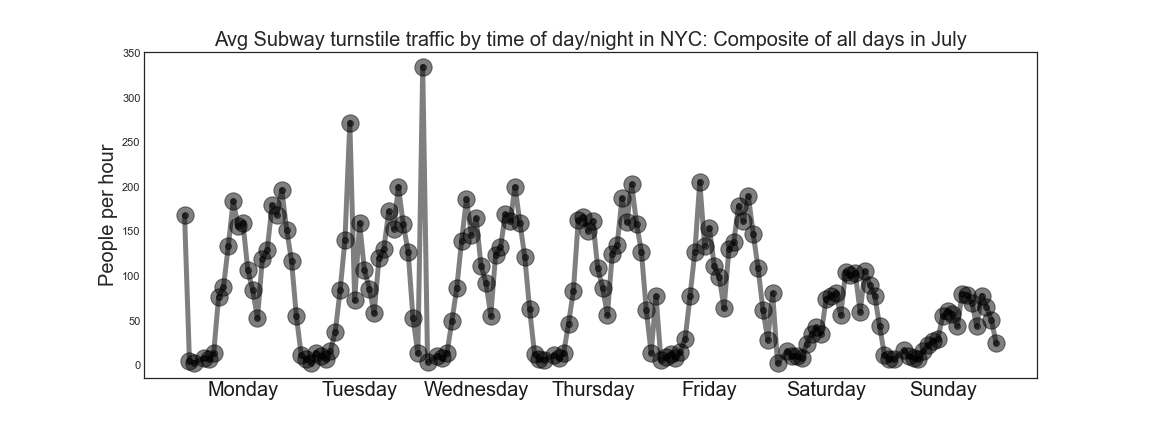

In [101]:
plt.figure(figsize=(16,6))

#station_list = turnstile_station['STATION'].unique().tolist()
station_list = list([stations_avg_by_day_hour])
# ticks_x = np.linspace(0.5, 6.5, 6)
# ticks_x = [0, 4, 8, 12, 16, 20]
# time_name = dict({0:'Midnight (12-4)', 4:'Dawn (4-8)', 8: 'Morning (8-noon)', 12: 'Afternoon (noon-4)',16:'Dusk (4-8)',20:'Night (8-midnight)'})
# times = [time_name[t] for t in ticks_x]
# #times =[0, 4, 8, 12, 16, 20]

ticks_x = np.linspace(0.5, 6.5, 7)
days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']
plt.xticks(ticks_x, days, fontsize = '20', color='k');

size_ = 300
alpha_ = .5

plt.title('Avg Subway turnstile traffic by time of day/night in NYC: Composite of all days in July', fontsize='20')
plt.ylabel('People per hour', fontsize='20')

neutral='black'

#for i in range(len(station_list)):
station=0
plt.scatter( x=station_list[station]['Day_hour'], y=station_list[station]['People_per_hour'], marker='o', s=(size_,), color=neutral, alpha=alpha_)
plt.plot( station_list[station]['Day_hour'], station_list[station]['People_per_hour'], marker='o',  color=neutral, alpha=alpha_, lw='5')


plt.savefig('Avg_Day_Hourly_turnstile_fluctuation_in_NYC.svg',transparent=True, bbox_inches='tight')

In [102]:
# plt.figure(figsize=(16,8))

# #station_list = turnstile_station['STATION'].unique().tolist()
# station_list = stations_avg_hourly
# # ticks_x = np.linspace(0.5, 6.5, 6)
# ticks_x = [0, 4, 8, 12, 16, 20]
# time_name = dict({0:'Midnight (12-4)', 4:'Dawn (4-8)', 8: 'Morning (8-noon)', 12: 'Afternoon (noon-4)',16:'Dusk (4-8)',20:'Night (8-midnight)'})
# times = [time_name[t] for t in ticks_x]
# #times =[0, 4, 8, 12, 16, 20]
# plt.xticks(ticks_x, times, fontsize = '15', color='k');
# size_ = 1000
# alpha_ = .7

# plt.title('Avg Subway turnstile traffic by time of day/night in the Flatiron area: Composite of all days in July', fontsize='20')
# plt.ylabel('People per hour', fontsize='20')

# #for i in range(len(station_list)):
# station=0
# plt.scatter( x=station_list[station]['Hour'], y=station_list[station]['People_per_hour'], marker='o', s=(size_,), color=colors_[4], alpha=alpha_)
# # station=1
# # plt.scatter( x=station_list[station]['Hour'], y=station_list[station]['People_per_hour'], marker='o', s=(size_,), color=colors_[station], alpha=alpha_)
# # station=2
# # plt.scatter( x=station_list[station]['Hour'], y=station_list[station]['People_per_hour'], marker='o', s=(size_,), color=colors_[station], alpha=alpha_)
# # station=3
# # plt.scatter( x=station_list[station]['Hour'], y=station_list[station]['People_per_hour'], marker='o', s=(size_,), color=colors_[station], alpha=alpha_)

# # plt.scatter( x=turnstile_station[turnstile_station['STATION']==station_list[1]]['Hour'], y=turnstile_station[turnstile_station['STATION']==station_list[1]]['People_per_hour'], marker='.', s=(size_,), alpha=alpha_)
# # plt.scatter( x=turnstile_station[turnstile_station['STATION']==station_list[2]]['Hour'], y=turnstile_station[turnstile_station['STATION']==station_list[2]]['People_per_hour'], marker='.', s=(size_,), alpha=alpha_)
# # plt.scatter( x=turnstile_station[turnstile_station['STATION']==station_list[3]]['Hour'], y=turnstile_station[turnstile_station['STATION']==station_list[3]]['People_per_hour'], marker='.', s=(size_,), alpha=alpha_)

# plt.savefig('Avg_Hourly_turnstile_fluctuation_in_NYC.svg',transparent=True, bbox_inches='tight')

In [103]:
#flatiron_station_list = ['turnstile_station['STATION'].unique().tolist()']

In [104]:
# # Four subway stops either in or near the Flatiron district
# flatiron = df_23st[df_23st['LINENAME'].str.contains('NRW')]
# gramercy = df_23st[df_23st['LINENAME'].str.contains('6')]
# east_chelsea = df_23st[df_23st['LINENAME'].str.contains('F')]
# union_sq = df[df['STATION'].str.contains('14 ST-UNION SQ')]


twenty_third_st_stations = turnstile_station[turnstile_station['STATION'].str.contains('23 ST')]
flatiron = twenty_third_st_stations[twenty_third_st_stations['LINENAME'].str.contains('N')]
gramercy = twenty_third_st_stations [twenty_third_st_stations ['LINENAME'].str.contains('6')]
sixth_ave_23 = twenty_third_st_stations[twenty_third_st_stations ['LINENAME'].str.contains('F')]
union_sq = turnstile_station[turnstile_station['STATION'].str.contains('14 ST-UNION SQ')]

flatiron_stations = [flatiron, gramercy, sixth_ave_23, union_sq]

flatiron_stations_avg_pp_day_hour = [station.groupby(['Day_hour']).agg({'People_per_hour': ['mean']}).reset_index() for station in flatiron_stations]
flatiron_stations_avg_pp_hour = [station.groupby(['Hour']).agg({'People_per_hour': ['mean']}).reset_index() for station in flatiron_stations]
flatiron_stations_avg_pp_day = [station.groupby(['Day_num']).agg({'People_per_hour': ['mean']}).reset_index() for station in flatiron_stations]

# flatiron_stations_avg = agg({'People_per_hour': ['mean']})

In [105]:
flatiron_stations_avg_pp_day_hour[0].head() 
#twenty_third_st_stations.sample(20)

,Day_hour,People_per_hour
,,mean
0,0.166667,3.250000
1,0.333333,31.607143
2,0.500000,169.035714
3,0.666667,133.535714
4,0.833333,262.062500


In [106]:
twenty_third_st_stations.sample(5) 

,STATION,LINENAME,Datetime,Day_of_week,Day_num,Hour,Day_hour,People_per_hour,GTFS Latitude,GTFS Longitude,income
8565,23 ST,NRW,2019-04-28 20:00:00,Sunday,6,20,6.833333,71.25,40.741303,-73.989344,104238.0
8867,23 ST,NRW,2019-05-07 04:00:00,Tuesday,1,4,1.166667,6.50,40.741303,-73.989344,104238.0
309066,23 ST,6,2019-05-07 17:00:00,Tuesday,1,17,1.708333,341.50,40.739864,-73.986599,104238.0
8552,23 ST,NRW,2019-05-10 16:00:00,Friday,4,16,4.666667,123.00,40.741303,-73.989344,104238.0
310013,23 ST,6,2019-04-29 07:56:03,Monday,0,7,0.291667,160.50,40.739864,-73.986599,104238.0


In [107]:
flatiron.head()


,STATION,LINENAME,Datetime,Day_of_week,Day_num,Hour,Day_hour,People_per_hour,GTFS Latitude,GTFS Longitude,income
7707,23 ST,NRW,2019-04-27 04:00:00,Saturday,5,4,5.166667,1.50,40.741303,-73.989344,104238.0
7708,23 ST,NRW,2019-04-27 08:00:00,Saturday,5,8,5.333333,13.25,40.741303,-73.989344,104238.0
7709,23 ST,NRW,2019-04-27 12:00:00,Saturday,5,12,5.500000,39.25,40.741303,-73.989344,104238.0
7710,23 ST,NRW,2019-04-27 16:00:00,Saturday,5,16,5.666667,69.00,40.741303,-73.989344,104238.0
7711,23 ST,NRW,2019-04-27 20:00:00,Saturday,5,20,5.833333,50.75,40.741303,-73.989344,104238.0


In [108]:

gramercy.head()

,STATION,LINENAME,Datetime,Day_of_week,Day_num,Hour,Day_hour,People_per_hour,GTFS Latitude,GTFS Longitude,income
309003,23 ST,6,2019-04-27 05:00:00,Saturday,5,5,5.208333,8.25,40.739864,-73.986599,104238.0
309004,23 ST,6,2019-04-27 09:00:00,Saturday,5,9,5.375000,51.75,40.739864,-73.986599,104238.0
309005,23 ST,6,2019-04-27 13:00:00,Saturday,5,13,5.541667,108.00,40.739864,-73.986599,104238.0
309006,23 ST,6,2019-04-27 17:00:00,Saturday,5,17,5.708333,134.50,40.739864,-73.986599,104238.0
309007,23 ST,6,2019-04-27 21:00:00,Saturday,5,21,5.875000,93.00,40.739864,-73.986599,104238.0


In [109]:
union_sq.head()

,STATION,LINENAME,Datetime,Day_of_week,Day_num,Hour,Day_hour,People_per_hour,GTFS Latitude,GTFS Longitude,income
8891,14 ST-UNION SQ,LNQR456W,2019-04-27 01:00:00,Saturday,5,1,5.041667,6.00,40.735066,-73.990416,92540.0
8892,14 ST-UNION SQ,LNQR456W,2019-04-27 05:00:00,Saturday,5,5,5.208333,3.25,40.735066,-73.990416,92540.0
8893,14 ST-UNION SQ,LNQR456W,2019-04-27 09:00:00,Saturday,5,9,5.375000,31.50,40.735066,-73.990416,92540.0
8894,14 ST-UNION SQ,LNQR456W,2019-04-27 13:00:00,Saturday,5,13,5.541667,140.75,40.735066,-73.990416,92540.0
8895,14 ST-UNION SQ,LNQR456W,2019-04-27 17:00:00,Saturday,5,17,5.708333,217.25,40.735066,-73.990416,92540.0


In [110]:
labels  = ['Flatiron', 'Gramercy','Sixth Ave. Chelsea', 'Union Sq']

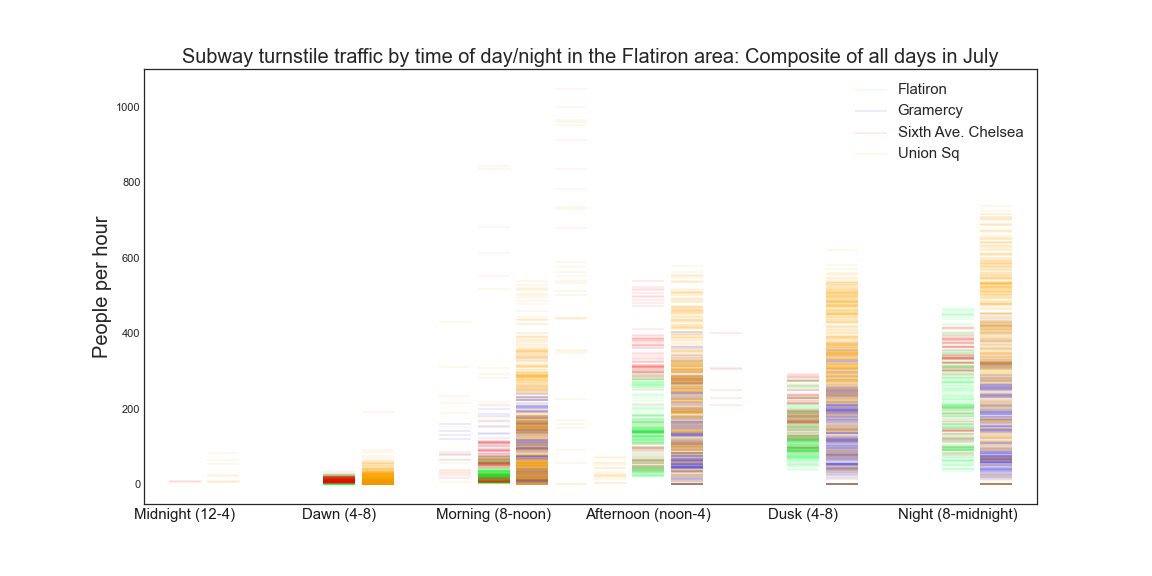

In [111]:
import numpy as np
plt.figure(figsize=(16,8))

#station_list = turnstile_station['STATION'].unique().tolist()
station_list = flatiron_stations

bright_green = '#00ff33'
colors_ = dict({0:bright_green, 1:'blue', 2: 'red', 3: 'orange'})

# ticks_x = np.linspace(0.5, 6.5, 6)
ticks_x = [0, 4, 8, 12, 16, 20]
time_name = dict({0:'Midnight (12-4)', 4:'Dawn (4-8)', 8: 'Morning (8-noon)', 12: 'Afternoon (noon-4)',16:'Dusk (4-8)',20:'Night (8-midnight)'})
times = [time_name[t] for t in ticks_x]
#times =[0, 4, 8, 12, 16, 20]
plt.xticks(ticks_x, times, fontsize = '15', color='k');
size_ = 1000
alpha_ = .1

plt.title('Subway turnstile traffic by time of day/night in the Flatiron area: Composite of all days in July', fontsize='20')
plt.ylabel('People per hour', fontsize='20')



#for i in range(len(station_list)):
plt.scatter( x=station_list[0]['Hour'], y=station_list[0]['People_per_hour'], marker='_', s=(size_,), color=colors_[0], alpha=alpha_, label=labels[0])
plt.scatter( x=station_list[1]['Hour'], y=station_list[1]['People_per_hour'], marker='_', s=(size_,), color=colors_[1], alpha=alpha_, label=labels[1])
plt.scatter( x=station_list[2]['Hour'], y=station_list[2]['People_per_hour'], marker='_', s=(size_,), color=colors_[2], alpha=alpha_, label=labels[2])
plt.scatter( x=station_list[3]['Hour'], y=station_list[3]['People_per_hour'], marker='_', s=(size_,), color=colors_[3], alpha=alpha_, label=labels[3])

# plt.scatter( x=turnstile_station[turnstile_station['STATION']==station_list[1]]['Hour'], y=turnstile_station[turnstile_station['STATION']==station_list[1]]['People_per_hour'], marker='.', s=(size_,), alpha=alpha_)
# plt.scatter( x=turnstile_station[turnstile_station['STATION']==station_list[2]]['Hour'], y=turnstile_station[turnstile_station['STATION']==station_list[2]]['People_per_hour'], marker='.', s=(size_,), alpha=alpha_)
# plt.scatter( x=turnstile_station[turnstile_station['STATION']==station_list[3]]['Hour'], y=turnstile_station[turnstile_station['STATION']==station_list[3]]['People_per_hour'], marker='.', s=(size_,), alpha=alpha_)

plt.legend(fontsize='15')
plt.savefig('Hourly_turnstile_fluctuation_at_4_stations.svg',transparent=True, bbox_inches='tight')

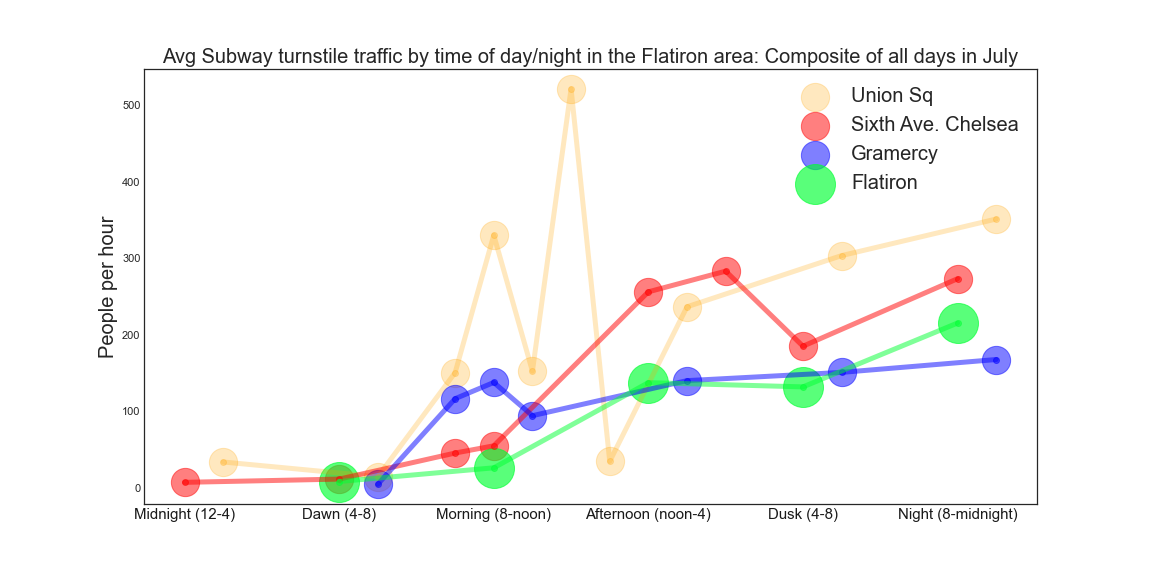

<Figure size 2880x720 with 0 Axes>

In [112]:
import numpy as np
plt.figure(figsize=(16,8))

#station_list = turnstile_station['STATION'].unique().tolist()
station_list = flatiron_stations_avg_pp_hour
# ticks_x = np.linspace(0.5, 6.5, 6)
ticks_x = [0, 4, 8, 12, 16, 20]
time_name = dict({0:'Midnight (12-4)', 4:'Dawn (4-8)', 8: 'Morning (8-noon)', 12: 'Afternoon (noon-4)',16:'Dusk (4-8)',20:'Night (8-midnight)'})
times = [time_name[t] for t in ticks_x]
#times =[0, 4, 8, 12, 16, 20]
plt.xticks(ticks_x, times, fontsize = '15', color='k');
size_ = 800
alpha_ = .5

colors_ = dict({0:bright_green, 1:'blue', 2: 'red', 3: 'orange'})

plt.title('Avg Subway turnstile traffic by time of day/night in the Flatiron area: Composite of all days in July', fontsize='20')
plt.ylabel('People per hour', fontsize='20')

#for i in range(len(station_list)):
alpha_*=.5
station=3
plt.scatter( x=station_list[station]['Hour'], y=station_list[station]['People_per_hour'], marker='o', s=(size_,), color=colors_[station], alpha=alpha_, label=labels[station])
plt.plot( station_list[station]['Hour'], station_list[station]['People_per_hour'], marker='o',  color=colors_[station], alpha=alpha_, lw='5')

alpha_ = .5
station=2
plt.scatter( x=station_list[station]['Hour'], y=station_list[station]['People_per_hour'], marker='o', s=(size_,), color=colors_[station], alpha=alpha_, label=labels[station])
plt.plot( station_list[station]['Hour'], station_list[station]['People_per_hour'], marker='o',  color=colors_[station], alpha=alpha_, lw='5')

station=1
plt.scatter( x=station_list[station]['Hour'], y=station_list[station]['People_per_hour'], marker='o', s=(size_,), color=colors_[station], alpha=alpha_, label=labels[station])
plt.plot( station_list[station]['Hour'], station_list[station]['People_per_hour'], marker='o',  color=colors_[station], alpha=alpha_, lw='5')


station=0
plt.scatter( x=station_list[station]['Hour'], y=station_list[station]['People_per_hour'], marker='o', s=(size_*2,), color=colors_[station], alpha=alpha_*1.3, label=labels[station])
plt.plot( station_list[station]['Hour'], station_list[station]['People_per_hour'], marker='o',  color=colors_[station], alpha=alpha_, lw='5')






# plt.scatter( x=turnstile_station[turnstile_station['STATION']==station_list[1]]['Hour'], y=turnstile_station[turnstile_station['STATION']==station_list[1]]['People_per_hour'], marker='.', s=(size_,), alpha=alpha_)
# plt.scatter( x=turnstile_station[turnstile_station['STATION']==station_list[2]]['Hour'], y=turnstile_station[turnstile_station['STATION']==station_list[2]]['People_per_hour'], marker='.', s=(size_,), alpha=alpha_)
# plt.scatter( x=turnstile_station[turnstile_station['STATION']==station_list[3]]['Hour'], y=turnstile_station[turnstile_station['STATION']==station_list[3]]['People_per_hour'], marker='.', s=(size_,), alpha=alpha_)

plt.legend(fontsize='20')
plt.show()
plt.savefig('Avg_Hourly_turnstile_fluctuation_at_4_stations.svg',transparent=True)

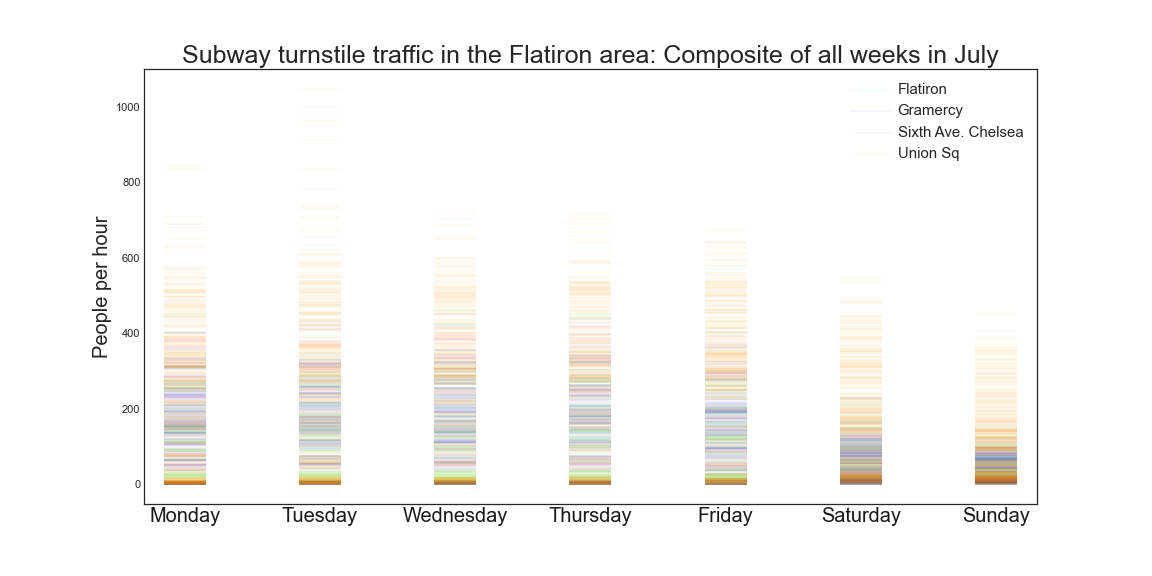

<Figure size 2880x720 with 0 Axes>

In [113]:
#station_list = turnstile_station['STATION'].unique().tolist()
colors_ = dict({0:bright_green, 1:'blue', 2: 'red', 3: 'orange'})

plt.figure(figsize=(16,8))

station_list = flatiron_stations

ticks_x = range(7)
days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']
plt.xticks(ticks_x, days, fontsize = '20', color='k');
size_ = 1800
alpha_ = .05

plt.title('Subway turnstile traffic in the Flatiron area: Composite of all weeks in July', fontsize='25')
plt.ylabel('People per hour', fontsize='20')

station=0
plt.scatter( x=station_list[station]['Day_num'], y=station_list[station]['People_per_hour'], marker='_', s=(size_,), color=colors_[station], alpha=alpha_, label=labels[station])
station=1
plt.scatter( x=station_list[station]['Day_num'], y=station_list[station]['People_per_hour'], marker='_', s=(size_,), color=colors_[station], alpha=alpha_, label=labels[station])
station=2
plt.scatter( x=station_list[station]['Day_num'], y=station_list[station]['People_per_hour'], marker='_', s=(size_,), color=colors_[station], alpha=alpha_, label=labels[station])
station=3
plt.scatter( x=station_list[station]['Day_num'], y=station_list[station]['People_per_hour'], marker='_', s=(size_,), color=colors_[station], alpha=alpha_, label=labels[station])



# plt.scatter( x=turnstile_station[turnstile_station['STATION']==station_list[0]]['Day_num'], y=turnstile_station[turnstile_station['STATION']==station_list[0]]['People_per_hour'], marker='.', s=(size_,), alpha=alpha_)
# plt.scatter( x=turnstile_station[turnstile_station['STATION']==station_list[1]]['Day_num'], y=turnstile_station[turnstile_station['STATION']==station_list[1]]['People_per_hour'], marker='.', s=(size_,), alpha=alpha_)
# plt.scatter( x=turnstile_station[turnstile_station['STATION']==station_list[2]]['Day_num'], y=turnstile_station[turnstile_station['STATION']==station_list[2]]['People_per_hour'], marker='.', s=(size_,), alpha=alpha_)
# plt.scatter( x=turnstile_station[turnstile_station['STATION']==station_list[3]]['Day_num'], y=turnstile_station[turnstile_station['STATION']==station_list[3]]['People_per_hour'], marker='.', s=(size_,), alpha=alpha_)

plt.legend(fontsize='15')
plt.show()


plt.savefig('Daily_turnstile_fluctuation_at_4_stations.svg',transparent=True, bbox_inches='tight')

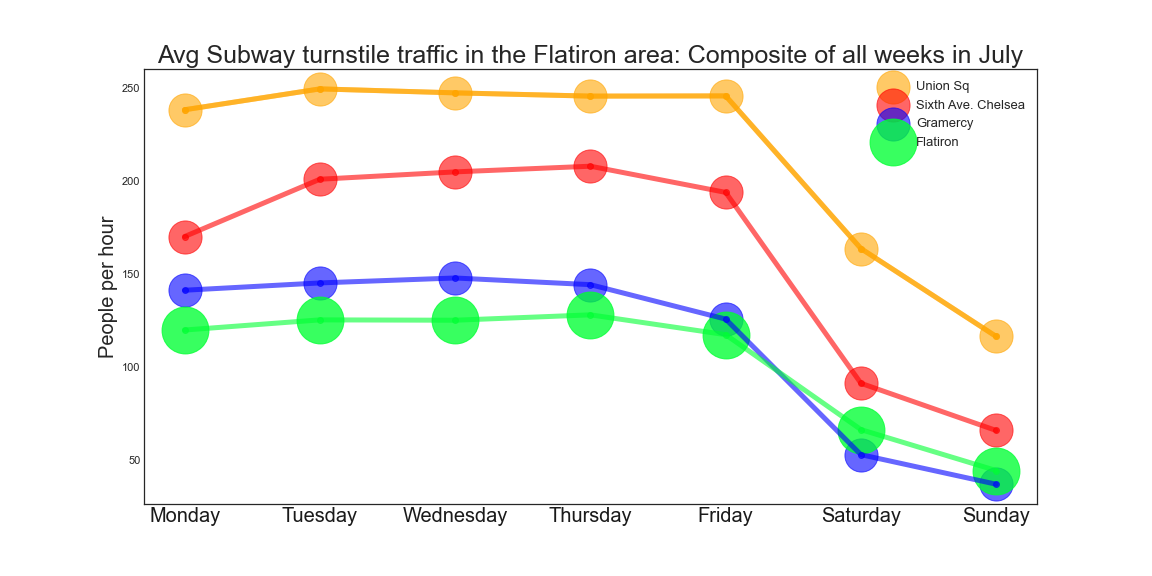

In [114]:
plt.figure(figsize=(16,8))

station_list  = flatiron_stations_avg_pp_day

colors_ = dict({0:bright_green, 1:'blue', 2: 'red', 3: 'orange'})

ticks_x = range(7)
days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']
plt.xticks(ticks_x, days, fontsize = '20', color='k');
size_ = 1100
alpha_ = .6

plt.title('Avg Subway turnstile traffic in the Flatiron area: Composite of all weeks in July', fontsize='25')
plt.ylabel('People per hour', fontsize='20')
plt.plot( station_list[station]['Day_num'], station_list[station]['People_per_hour'], marker='o', color=colors_[station], alpha=alpha_, lw='5')


station=3
plt.scatter( x=station_list[station]['Day_num'], y=station_list[station]['People_per_hour'], marker='o', s=(size_,), color=colors_[station], alpha=alpha_, label=labels[station])
plt.plot( station_list[station]['Day_num'], station_list[station]['People_per_hour'], marker='o', color=colors_[station], alpha=alpha_, lw='5')

station=2
plt.scatter( x=station_list[station]['Day_num'], y=station_list[station]['People_per_hour'], marker='o', s=(size_,), color=colors_[station], alpha=alpha_, label=labels[station])
plt.plot( station_list[station]['Day_num'], station_list[station]['People_per_hour'], marker='o', color=colors_[station], alpha=alpha_, lw='5')

station=1
plt.scatter( x=station_list[station]['Day_num'], y=station_list[station]['People_per_hour'], marker='o', s=(size_,), color=colors_[station], alpha=alpha_, label=labels[station])
plt.plot( station_list[station]['Day_num'], station_list[station]['People_per_hour'], marker='o', color=colors_[station], alpha=alpha_, lw='5')

station=0
plt.scatter( x=station_list[station]['Day_num'], y=station_list[station]['People_per_hour'], marker='o', s=(size_*2,), color=colors_[station], alpha=alpha_*1.3, label=labels[station])
plt.plot( station_list[station]['Day_num'], station_list[station]['People_per_hour'], marker='o', color=colors_[station], alpha=alpha_, lw='5')


# plt.scatter( x=turnstile_station[turnstile_station['STATION']==station_list[0]]['Day_num'], y=turnstile_station[turnstile_station['STATION']==station_list[0]]['People_per_hour'], marker='.', s=(size_,), alpha=alpha_)
# plt.scatter( x=turnstile_station[turnstile_station['STATION']==station_list[1]]['Day_num'], y=turnstile_station[turnstile_station['STATION']==station_list[1]]['People_per_hour'], marker='.', s=(size_,), alpha=alpha_)
# plt.scatter( x=turnstile_station[turnstile_station['STATION']==station_list[2]]['Day_num'], y=turnstile_station[turnstile_station['STATION']==station_list[2]]['People_per_hour'], marker='.', s=(size_,), alpha=alpha_)
# plt.scatter( x=turnstile_station[turnstile_station['STATION']==station_list[3]]['Day_num'], y=turnstile_station[turnstile_station['STATION']==station_list[3]]['People_per_hour'], marker='.', s=(size_,), alpha=alpha_)
plt.legend(fontsize='13')
plt.savefig('Avg_Daily_turnstile_fluctuation_at_4_stations.svg',transparent=True)

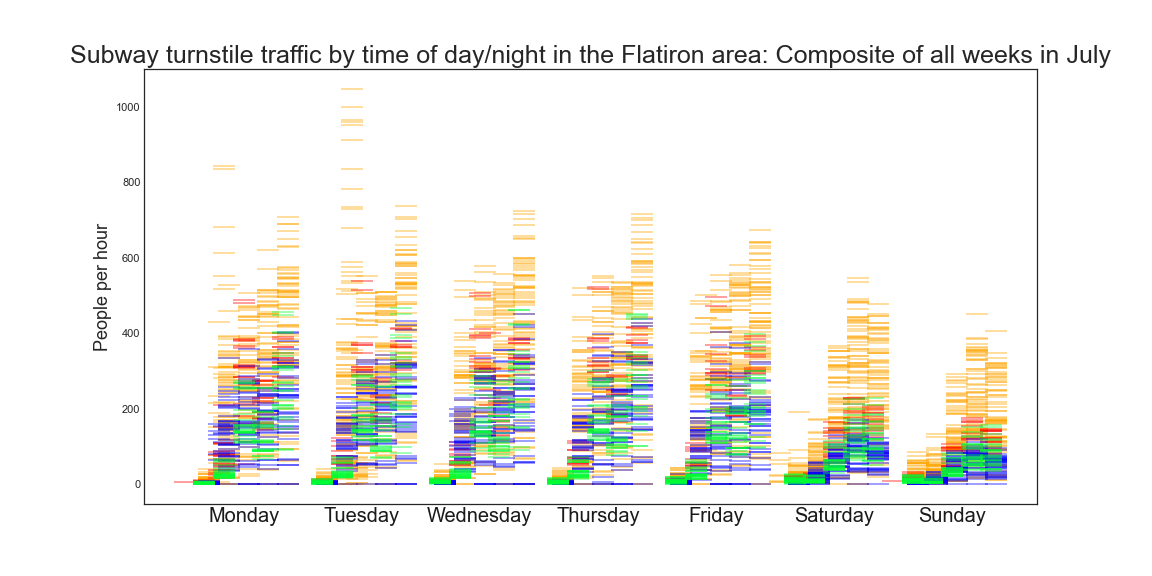

In [115]:
plt.figure(figsize=(16,8))

station_list = flatiron_stations

#station_list = turnstile_station['STATION'].unique().tolist()
ticks_x = np.linspace(0.5, 6.5, 7)
days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']
plt.xticks(ticks_x, days, fontsize = '20', color='k');
size_ = 500
alpha_ = .5


plt.title('Subway turnstile traffic by time of day/night in the Flatiron area: Composite of all weeks in July', fontsize='25')
plt.ylabel('People per hour', fontsize='18')
#plt.ylim(0, 1000)
# # plt.scatter( x=turnstile_station[turnstile_station['STATION']==station_list[0]]['Day_hour'], y=turnstile_station[turnstile_station['STATION']==station_list[0]]['People_per_hour'], marker='.', s=(size_,), alpha = alpha_)
# # plt.scatter( x=turnstile_station[turnstile_station['STATION']==station_list[1]]['Day_hour'], y=turnstile_station[turnstile_station['STATION']==station_list[1]]['People_per_hour'], marker='.', s=(size_,),  alpha = alpha_)
# # plt.scatter( x=turnstile_station[turnstile_station['STATION']==station_list[2]]['Day_hour'], y=turnstile_station[turnstile_station['STATION']==station_list[2]]['People_per_hour'], marker='.', s=(size_,),  alpha = alpha_)
# # plt.scatter( x=turnstile_station[turnstile_station['STATION']==station_list[3]]['Day_hour'], y=turnstile_station[turnstile_station['STATION']==station_list[3]]['People_per_hour'], marker='.', s=(size_,),  alpha = alpha_)

plt.scatter( x=station_list[3]['Day_hour'], y=station_list[3]['People_per_hour'], marker='_', s=(size_,), color='orange', alpha=alpha_)
plt.scatter( x=station_list[2]['Day_hour'], y=station_list[2]['People_per_hour'], marker='_', s=(size_,), color='red', alpha=alpha_)
plt.scatter( x=station_list[1]['Day_hour'], y=station_list[1]['People_per_hour'], marker='_', s=(size_,), color='blue', alpha=alpha_)
plt.scatter( x=station_list[0]['Day_hour'], y=station_list[0]['People_per_hour'], marker='_', s=(size_,), color='#00ff33', alpha=alpha_)


plt.savefig('Day_hourly_turnstile_fluctuation_at_4_stations.svg',transparent=True);


In [116]:
station_list = flatiron_stations_avg_pp_day_hour

In [117]:
station_list = flatiron_stations_avg_pp_day_hour

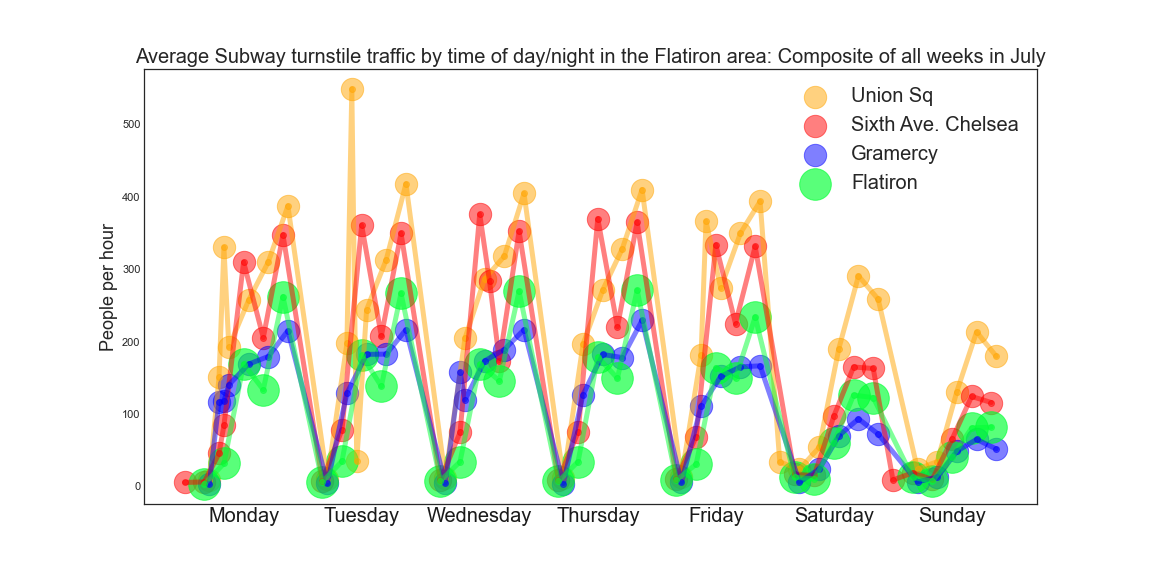

In [118]:
import numpy as np

station_list = flatiron_stations_avg_pp_day_hour

plt.figure(figsize=(16,8))

#station_list = turnstile_station['STATION'].unique().tolist()
ticks_x = np.linspace(0.5, 6.5, 7)
days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']
plt.xticks(ticks_x, days, fontsize = '20', color='k');
size_ = 500
alpha_ = .5
#plt.ylim(0, 750)

plt.title('Average Subway turnstile traffic by time of day/night in the Flatiron area: Composite of all weeks in July', fontsize='20')
plt.ylabel('People per hour', fontsize='18')

# plt.scatter( x=turnstile_station[turnstile_station['STATION']==station_list[0]]['Day_hour'], y=turnstile_station[turnstile_station['STATION']==station_list[0]]['People_per_hour'], marker='.', s=(size_,), alpha = alpha_)
# plt.scatter( x=turnstile_station[turnstile_station['STATION']==station_list[1]]['Day_hour'], y=turnstile_station[turnstile_station['STATION']==station_list[1]]['People_per_hour'], marker='.', s=(size_,),  alpha = alpha_)
# plt.scatter( x=turnstile_station[turnstile_station['STATION']==station_list[2]]['Day_hour'], y=turnstile_station[turnstile_station['STATION']==station_list[2]]['People_per_hour'], marker='.', s=(size_,),  alpha = alpha_)
# plt.scatter( x=turnstile_station[turnstile_station['STATION']==station_list[3]]['Day_hour'], y=turnstile_station[turnstile_station['STATION']==station_list[3]]['People_per_hour'], marker='.', s=(size_,),  alpha = alpha_)

# zeroeth = 'Flatiron'
# first='Gramercy'
# second = 'Sixth Ave. Chelsea'
# third = 'Union Sq'

# plt.legend(handles = [zeroeth, first, ], 
#            labels  = ['Line', 'Sine', 'Arcsine'])




station=3
plt.scatter( x=station_list[station]['Day_hour'], y=station_list[station]['People_per_hour'], marker='o', s=(size_,), color=colors_[station], alpha=alpha_, label=labels[station])
plt.plot( station_list[station]['Day_hour'], station_list[station]['People_per_hour'], marker='o', color=colors_[station], alpha=alpha_, lw='5')

station=2
plt.scatter( x=station_list[station]['Day_hour'], y=station_list[station]['People_per_hour'], marker='o', s=(size_,), color=colors_[station], alpha=alpha_, label=labels[station])
plt.plot( station_list[station]['Day_hour'], station_list[station]['People_per_hour'], marker='o', color=colors_[station], alpha=alpha_, lw='5')

station=1
plt.scatter( x=station_list[station]['Day_hour'], y=station_list[station]['People_per_hour'], marker='o', s=(size_,), color=colors_[station], alpha=alpha_, label=labels[station])
plt.plot( station_list[station]['Day_hour'], station_list[station]['People_per_hour'], marker='o', color=colors_[station], alpha=alpha_, lw='5')

station=0
plt.scatter( x=station_list[station]['Day_hour'], y=station_list[station]['People_per_hour'], marker='o', s=(size_*2,), color=colors_[station], alpha=alpha_*1.3, label=labels[station])
plt.plot( station_list[station]['Day_hour'], station_list[station]['People_per_hour'], marker='o', color=colors_[station], alpha=alpha_, lw='5')

plt.legend(fontsize=20)

plt.savefig('Avg_Day_hourly_turnstile_fluctuation_at_4_stations.svg',transparent=True)
plt.show()

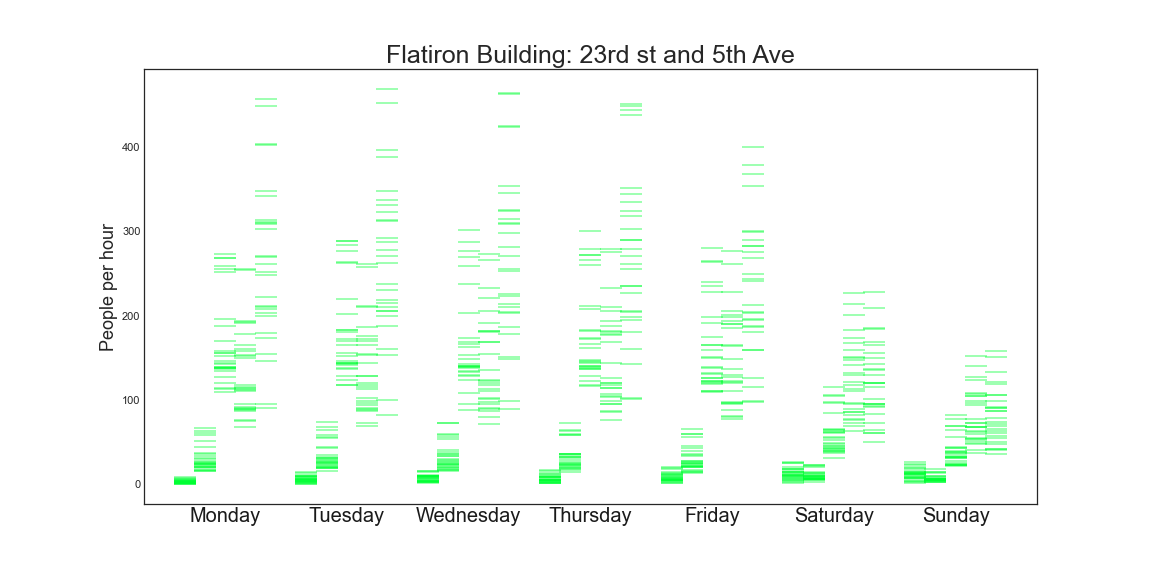

In [119]:
station_list = flatiron_stations

plt.figure(figsize=(16,8))

#station_list = turnstile_station['STATION'].unique().tolist()
ticks_x = np.linspace(0.5, 6.5, 7)
days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']
plt.xticks(ticks_x, days, fontsize = '20', color='k');
size_ = 500
alpha_ = .5

#plt.ylim([0, 1000])
plt.title('Flatiron Building: 23rd st and 5th Ave', fontsize='25')

plt.ylabel('People per hour', fontsize='18')

plt.scatter( x=station_list[0]['Day_hour'], y=station_list[0]['People_per_hour'], marker='_', s=(size_,), color=bright_green, alpha=alpha_)


plt.savefig('Day_hourly_turnstile_fluctuation_at_flatiron_station.svg',transparent=True)

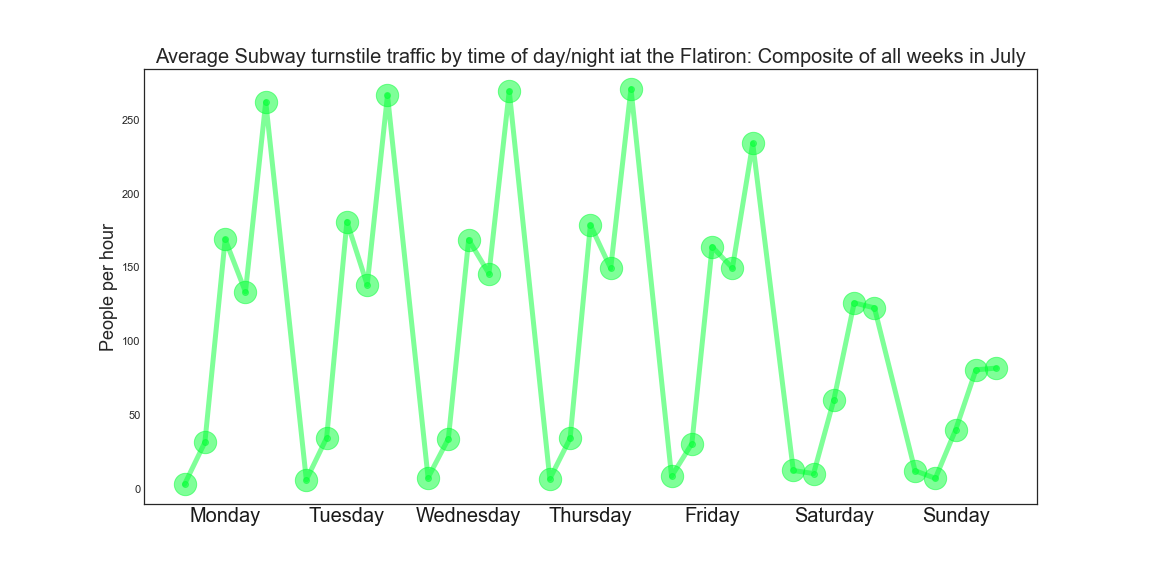

In [120]:
station_list = flatiron_stations_avg_pp_day_hour

plt.figure(figsize=(16,8))

#station_list = turnstile_station['STATION'].unique().tolist()
ticks_x = np.linspace(0.5, 6.5, 7)
days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']
plt.xticks(ticks_x, days, fontsize = '20', color='k');
size_ = 500
alpha_ = .5
#plt.ylim([0, 300])

plt.title('Average Subway turnstile traffic by time of day/night iat the Flatiron: Composite of all weeks in July', fontsize='20')
plt.ylabel('People per hour', fontsize='18')

# plt.scatter( x=turnstile_station[turnstile_station['STATION']==station_list[0]]['Day_hour'], y=turnstile_station[turnstile_station['STATION']==station_list[0]]['People_per_hour'], marker='.', s=(size_,), alpha = alpha_)
# plt.scatter( x=turnstile_station[turnstile_station['STATION']==station_list[1]]['Day_hour'], y=turnstile_station[turnstile_station['STATION']==station_list[1]]['People_per_hour'], marker='.', s=(size_,),  alpha = alpha_)
# plt.scatter( x=turnstile_station[turnstile_station['STATION']==station_list[2]]['Day_hour'], y=turnstile_station[turnstile_station['STATION']==station_list[2]]['People_per_hour'], marker='.', s=(size_,),  alpha = alpha_)
# plt.scatter( x=turnstile_station[turnstile_station['STATION']==station_list[3]]['Day_hour'], y=turnstile_station[turnstile_station['STATION']==station_list[3]]['People_per_hour'], marker='.', s=(size_,),  alpha = alpha_)


station=0
plt.scatter( x=station_list[station]['Day_hour'], y=station_list[station]['People_per_hour'], marker='o', s=(size_,), color=colors_[station], alpha=alpha_)
plt.plot( station_list[station]['Day_hour'], station_list[station]['People_per_hour'], marker='o', color=colors_[station], alpha=alpha_, lw='5')

plt.savefig('Avg_Day_hourly_turnstile_fluctuation_at_flatiron_station.svg',transparent=True)

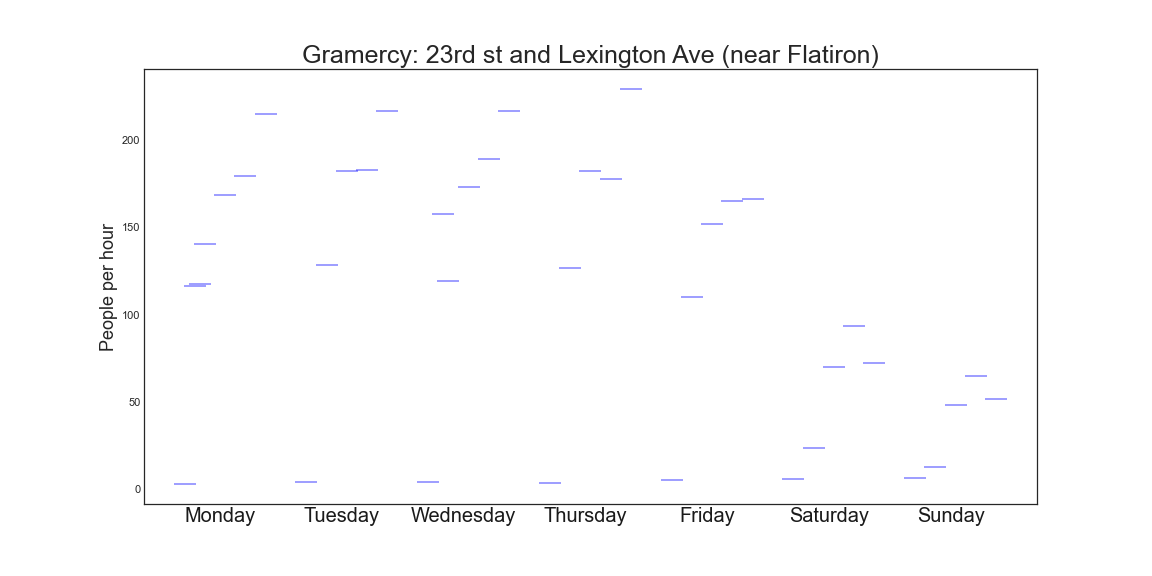

In [121]:
plt.figure(figsize=(16,8))

#station_list = turnstile_station['STATION'].unique().tolist()
ticks_x = np.linspace(0.5, 6.5, 7)
days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']
plt.xticks(ticks_x, days, fontsize = '20', color='k');
size_ = 500
alpha_ = .5

#plt.ylim([0, 1000])
plt.title('Gramercy: 23rd st and Lexington Ave (near Flatiron)', fontsize='25')

plt.ylabel('People per hour', fontsize='18')

plt.scatter( x=station_list[1]['Day_hour'], y=station_list[1]['People_per_hour'], marker='_', s=(size_,), color='blue', alpha=alpha_);


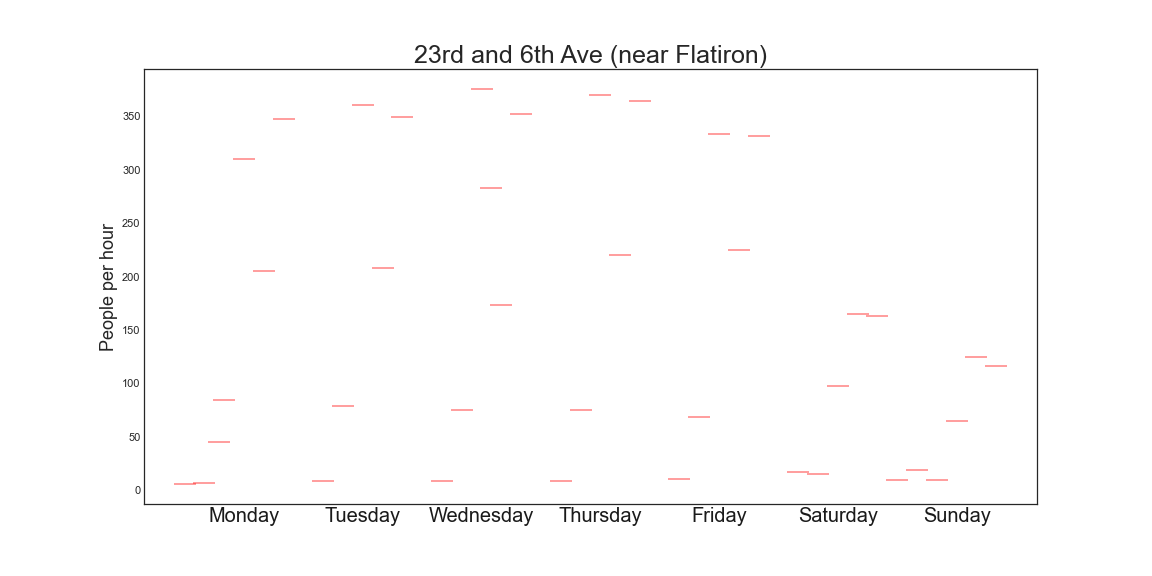

In [122]:
plt.figure(figsize=(16,8))

#station_list = turnstile_station['STATION'].unique().tolist()
ticks_x = np.linspace(0.5, 6.5, 7)
days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']
plt.xticks(ticks_x, days, fontsize = '20', color='k');
size_ = 500
alpha_ = .5

#plt.ylim([0, 1000])
plt.title('23rd and 6th Ave (near Flatiron)', fontsize='25')

plt.ylabel('People per hour', fontsize='18')

plt.scatter( x=station_list[2]['Day_hour'], y=station_list[2]['People_per_hour'], marker='_', s=(size_,), color='red', alpha=alpha_)
plt.savefig('Avg_Day_hourly_turnstile_fluctuation_at_Gramercy_station.svg',transparent=True)

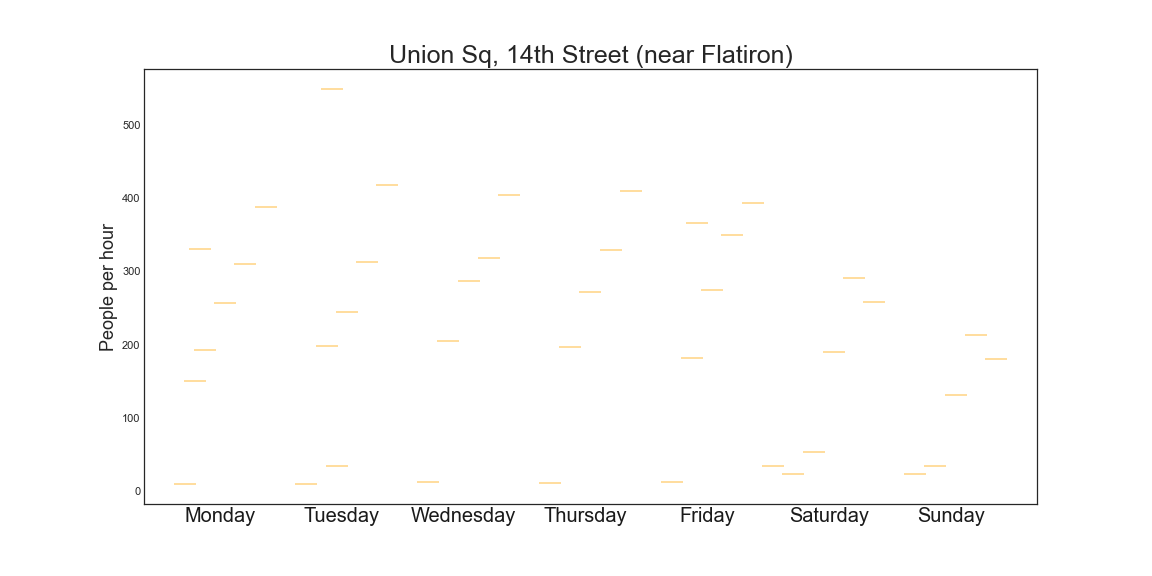

In [123]:
plt.figure(figsize=(16,8))

#station_list = turnstile_station['STATION'].unique().tolist()
ticks_x = np.linspace(0.5, 6.5, 7)
days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']
plt.xticks(ticks_x, days, fontsize = '20', color='k');
size_ = 500
alpha_ = .5

#plt.ylim([0, 1000])
plt.title('Union Sq, 14th Street (near Flatiron)', fontsize='25')

plt.ylabel('People per hour', fontsize='18')

plt.scatter( x=station_list[3]['Day_hour'], y=station_list[3]['People_per_hour'], marker='_', s=(size_,), color='orange', alpha=alpha_)


In [124]:
Flatiron_avg = station_list[0].groupby(['Day_hour']).mean().reset_index()
Flatiron_avg.head()

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:3887: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


,Day_hour,People_per_hour
,,mean
0,0.166667,3.250000
1,0.333333,31.607143
2,0.500000,169.035714
3,0.666667,133.535714
4,0.833333,262.062500


In [125]:


# plt.figure(figsize=(16,5))

# #station_list = turnstile_station['STATION'].unique().tolist()
# ticks_x = np.linspace(0.5, 6.5, 7)
# days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']
# plt.xticks(ticks_x, days, fontsize = '20', color='k');
# size_ = 600
# alpha_ = 1

# #plt.ylim([0, 300])
# plt.title('Flatiron Building: 23rd st and 5th Ave', fontsize='25')

# plt.ylabel('Avg People per hour', fontsize='18')

# #plt.scatter( x=Flatiron_avg['Day_hour'], y=Flatiron_avg['People_per_hour'], marker='o', s=(size_,), color='green', alpha=alpha_)
# plt.scatter( x=flatiron_stations_avg[0]['Day_hour'], y=flatiron_stations_avg[0]['People_per_hour'], marker='o', s=(size_,), color='green', alpha=alpha_)


### Flatiron train station in particular is shown below

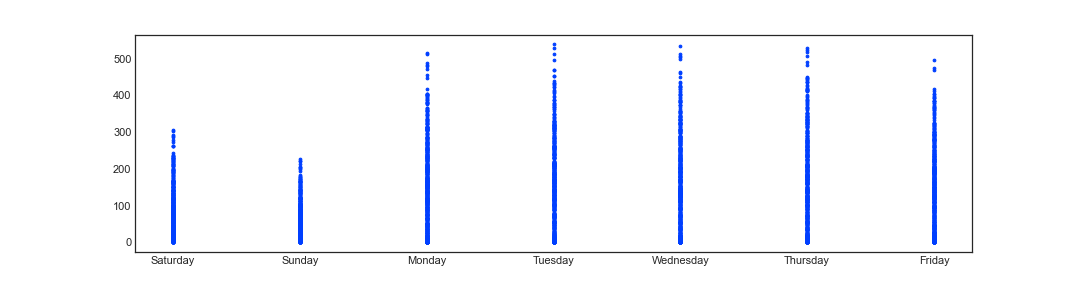

In [126]:
flatiron_turnstile_summary = turnstile_station[turnstile_station['STATION'].str.contains('23 ST')]
plt.figure(figsize=(15,4))
plt.scatter( x=flatiron_turnstile_summary['Day_of_week'], y=flatiron_turnstile_summary['People_per_hour'], marker='.', s=(30,))


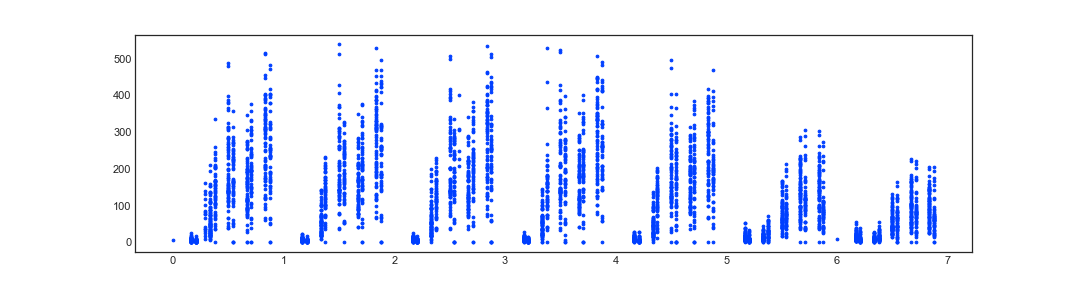

In [127]:
plt.figure(figsize=(15,4))
plt.scatter( x=flatiron_turnstile_summary['Day_hour'], y=flatiron_turnstile_summary['People_per_hour'], marker='.', s=(30,))


In [128]:
station_level = turnstile_station.groupby(['STATION','LINENAME'])[['income','People_per_hour','GTFS Latitude','GTFS Longitude']].agg('mean').reset_index().sort_values(('income'),ascending=False)

station_level.sort_values(by=['income'],ascending=False)

# we know several of our top stations are connected. lets collapse / remove those (i.e. WTC, Etc.)
stations_rm_wtc = station_level[(station_level['STATION'] == ('CITY HALL')) |
                                (station_level['STATION']==('CHAMBERS ST')) |
                                (station_level['STATION']==('CORTLANDT ST')) |
                                (station_level['STATION']==('WTC-CORTLANDT')) |
                                (station_level['STATION']==('HUNTERS PT AV')) |
                                (station_level['STATION']==('21 ST')) |
                                (station_level['STATION']==('WHITEHALL S-FRY')) |
                                (station_level['STATION']==('SOUTH FERRY'))
                               ].index

stations_rm = station_level.drop(stations_rm_wtc)

stations_top10inc = stations_rm.nlargest(15,['income'])
stations_top3inc= stations_rm.nlargest(3,['income'])
stations_top3inc.shape

(3, 6)

In [129]:
station_level

,STATION,LINENAME,income,People_per_hour,GTFS Latitude,GTFS Longitude
473,WTC-CORTLANDT,1,216037.0,41.509560,40.711835,-74.012188
259,CORTLANDT ST,RNW,216037.0,45.946401,40.712603,-74.009551
472,WORLD TRADE CTR,ACE23,216037.0,82.714931,40.712603,-74.009551
251,CITY HALL,NRW,216037.0,42.033892,40.713282,-74.006978
243,CHAMBERS ST,ACE23,216037.0,77.856864,40.712603,-74.009551
...,...,...,...,...,...,...
420,RIT-ROOSEVELT,R,NaN,43.958333,NaN,NaN
443,THIRTY ST,1,NaN,56.539194,NaN,NaN
444,THIRTY THIRD ST,1,NaN,113.206159,NaN,NaN
450,TWENTY THIRD ST,1,NaN,97.776471,NaN,NaN


In [130]:
stations_top10inc.head(15)

,STATION,LINENAME,income,People_per_hour,GTFS Latitude,GTFS Longitude
472,WORLD TRADE CTR,ACE23,216037.0,82.714931,40.712603,-74.009551
397,PARK PLACE,23ACE,216037.0,61.401292,40.712603,-74.009551
130,66 ST-LINCOLN,1,170630.0,111.161760,40.773440,-73.982209
164,96 ST,123,168667.0,153.303746,40.793919,-73.972323
157,86 ST,BC,168667.0,68.162978,40.785868,-73.968916
3,103 ST,BC,168667.0,113.696429,40.796092,-73.961454
155,86 ST,1,168667.0,111.041071,40.788644,-73.976218
166,96 ST,BC,168667.0,95.419719,40.791642,-73.964696
217,BOWLING GREEN,45,129574.0,90.461170,40.704817,-74.014065
457,VERNON-JACKSON,7,125871.0,95.219961,40.742626,-73.953581


In [131]:
stations_top10inc.columns

Index(['STATION', 'LINENAME', 'income', 'People_per_hour', 'GTFS Latitude',
       'GTFS Longitude'],
      dtype='object')

In [132]:
turnstile_station.head()

,STATION,LINENAME,Datetime,Day_of_week,Day_num,Hour,Day_hour,People_per_hour,GTFS Latitude,GTFS Longitude,income
1,59 ST,NQR456W,2019-04-27 04:00:00,Saturday,5,4,5.166667,6.75,40.762593,-73.967612,112269.0
2,59 ST,NQR456W,2019-04-27 08:00:00,Saturday,5,8,5.333333,14.50,40.762593,-73.967612,112269.0
3,59 ST,NQR456W,2019-04-27 12:00:00,Saturday,5,12,5.500000,44.00,40.762593,-73.967612,112269.0
4,59 ST,NQR456W,2019-04-27 16:00:00,Saturday,5,16,5.666667,82.00,40.762593,-73.967612,112269.0
5,59 ST,NQR456W,2019-04-27 20:00:00,Saturday,5,20,5.833333,82.25,40.762593,-73.967612,112269.0


In [133]:
stations_top10inc_turnstile = turnstile_station.merge(stations_top10inc[['STATION', 'LINENAME','income']], how='inner', on=['STATION', 'LINENAME'])
#turnstile_station.drop(columns=["Stop Name"], inplace=True)
stations_top10inc_turnstile.head(3)

,STATION,LINENAME,Datetime,Day_of_week,Day_num,Hour,Day_hour,People_per_hour,GTFS Latitude,GTFS Longitude,income_x,income_y
0,RECTOR ST,NRW,2019-04-27 04:00:00,Saturday,5,4,5.166667,3.00,40.70722,-74.013342,119274.0,119274.0
1,RECTOR ST,NRW,2019-04-27 08:00:00,Saturday,5,8,5.333333,12.75,40.70722,-74.013342,119274.0,119274.0
2,RECTOR ST,NRW,2019-04-27 12:00:00,Saturday,5,12,5.500000,41.25,40.70722,-74.013342,119274.0,119274.0


In [134]:
stations_top3inc_turnstile = turnstile_station.merge(stations_top3inc[['STATION', 'LINENAME','income']], on=['STATION', 'LINENAME'],how="inner")
#turnstile_station.drop(columns=["Stop Name"], inplace=True)
stations_top3inc_turnstile.head(3)
stations_top3inc_names = ["World Trace CTR", "Park Place", "Lincoln Center"]


In [135]:
# union_sq = turnstile_station[turnstile_station['STATION'].str.contains('14 ST-UNION SQ')]



wtc        = stations_top3inc_turnstile[stations_top3inc_turnstile['STATION'].str.contains("WORLD TRADE CTR")]
park_place = stations_top3inc_turnstile[stations_top3inc_turnstile['STATION'].str.contains("PARK PLACE")]
lincoln_center   = stations_top3inc_turnstile[stations_top3inc_turnstile['STATION'].str.contains('LINCOLN')]

top3_stations_list = [wtc, park_place, lincoln_center]


station_list = list([ stations_top3inc_turnstile[stations_top3inc_turnstile['STATION']==stations_top3inc.iloc[R,:]["STATION"]] for R in range(stations_top3inc.shape[0]) ])
                                                                                                                                                
                                                                                                                                                
station_list[2]
                                                                                                                                                                                                                                                                                                
                                                                                                                                                
                                                                                                                                                

,STATION,LINENAME,Datetime,Day_of_week,Day_num,Hour,Day_hour,People_per_hour,GTFS Latitude,GTFS Longitude,income_x,income_y
1433,66 ST-LINCOLN,1,2019-04-27 05:00:00,Saturday,5,5,5.208333,16.00,40.77344,-73.982209,170630.0,170630.0
1434,66 ST-LINCOLN,1,2019-04-27 09:00:00,Saturday,5,9,5.375000,39.25,40.77344,-73.982209,170630.0,170630.0
1435,66 ST-LINCOLN,1,2019-04-27 13:00:00,Saturday,5,13,5.541667,120.00,40.77344,-73.982209,170630.0,170630.0
1436,66 ST-LINCOLN,1,2019-04-27 17:00:00,Saturday,5,17,5.708333,163.50,40.77344,-73.982209,170630.0,170630.0
1437,66 ST-LINCOLN,1,2019-04-27 21:00:00,Saturday,5,21,5.875000,134.50,40.77344,-73.982209,170630.0,170630.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2583,66 ST-LINCOLN,1,2019-05-10 05:00:00,Friday,4,5,4.208333,0.25,40.77344,-73.982209,170630.0,170630.0
2584,66 ST-LINCOLN,1,2019-05-10 09:00:00,Friday,4,9,4.375000,10.00,40.77344,-73.982209,170630.0,170630.0
2585,66 ST-LINCOLN,1,2019-05-10 13:00:00,Friday,4,13,4.541667,8.25,40.77344,-73.982209,170630.0,170630.0
2586,66 ST-LINCOLN,1,2019-05-10 17:00:00,Friday,4,17,4.708333,29.25,40.77344,-73.982209,170630.0,170630.0


In [136]:
new_colors_ = dict({0:'darkviolet', 1:'tomato', 2: 'mediumturquoise', 3: 'yellowgreen'})

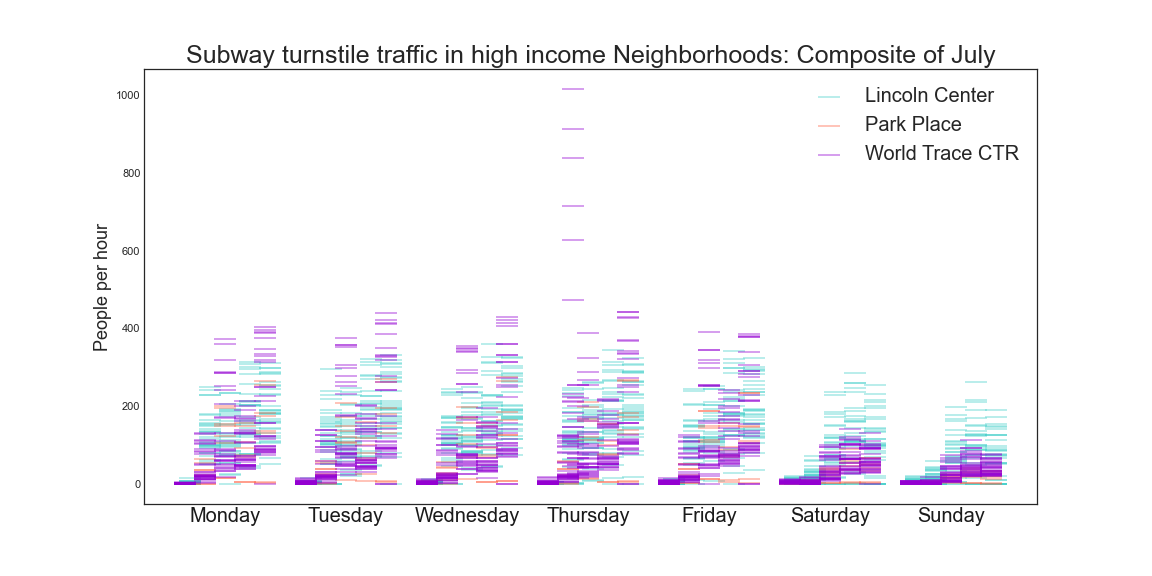

In [137]:
plt.figure(figsize=(16,8))                                                  

#station_list = turnstile_station['STATION'].unique().tolist()
ticks_x = np.linspace(0.5, 6.5, 7)
days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']
plt.xticks(ticks_x, days, fontsize = '20', color='k');
size_ = 500
alpha_ = .5
#plt.ylim([0, 1000])

plt.title('Subway turnstile traffic in high income Neighborhoods: Composite of July', fontsize='25')
plt.ylabel('People per hour', fontsize='18')

# plt.scatter( x=turnstile_station[turnstile_station['STATION']==station_list[0]]['Day_hour'], y=turnstile_station[turnstile_station['STATION']==station_list[0]]['People_per_hour'], marker='.', s=(size_,), alpha = alpha_)
# plt.scatter( x=turnstile_station[turnstile_station['STATION']==station_list[1]]['Day_hour'], y=turnstile_station[turnstile_station['STATION']==station_list[1]]['People_per_hour'], marker='.', s=(size_,),  alpha = alpha_)
# plt.scatter( x=turnstile_station[turnstile_station['STATION']==station_list[2]]['Day_hour'], y=turnstile_station[turnstile_station['STATION']==station_list[2]]['People_per_hour'], marker='.', s=(size_,),  alpha = alpha_)
# plt.scatter( x=turnstile_station[turnstile_station['STATION']==station_list[3]]['Day_hour'], y=turnstile_station[turnstile_station['STATION']==station_list[3]]['People_per_hour'], marker='.', s=(size_,),  alpha = alpha_)

#plt.scatter( x=station_list[3]['Day_hour'], y=station_list[3]['People_per_hour'], marker='_', s=(size_,),  alpha=alpha_)

labels = stations_top3inc_names

station=2
plt.scatter( x=station_list[station]['Day_hour'], y=station_list[station]['People_per_hour'], marker='_', s=(size_,),  alpha=alpha_, color=new_colors_[station], label=labels[station])
station=1
plt.scatter( x=station_list[station]['Day_hour'], y=station_list[station]['People_per_hour'], marker='_', s=(size_,), alpha=alpha_, color=new_colors_[station], label=labels[station])
station=0
plt.scatter( x=station_list[station]['Day_hour'], y=station_list[0]['People_per_hour'], marker='_', s=(size_,),  alpha=alpha_, color=new_colors_[station], label=labels[station])

plt.legend(fontsize=20)


plt.savefig('Day_hourly_turnstile_fluctuation_at_Highest_Income.svg',transparent=True)


In [138]:
top3_stations_list[2].head()

,STATION,LINENAME,Datetime,Day_of_week,Day_num,Hour,Day_hour,People_per_hour,GTFS Latitude,GTFS Longitude,income_x,income_y
1433,66 ST-LINCOLN,1,2019-04-27 05:00:00,Saturday,5,5,5.208333,16.00,40.77344,-73.982209,170630.0,170630.0
1434,66 ST-LINCOLN,1,2019-04-27 09:00:00,Saturday,5,9,5.375000,39.25,40.77344,-73.982209,170630.0,170630.0
1435,66 ST-LINCOLN,1,2019-04-27 13:00:00,Saturday,5,13,5.541667,120.00,40.77344,-73.982209,170630.0,170630.0
1436,66 ST-LINCOLN,1,2019-04-27 17:00:00,Saturday,5,17,5.708333,163.50,40.77344,-73.982209,170630.0,170630.0
1437,66 ST-LINCOLN,1,2019-04-27 21:00:00,Saturday,5,21,5.875000,134.50,40.77344,-73.982209,170630.0,170630.0


In [139]:
High_income_stations_avg_pp_day_hour = [station.groupby(['Day_hour']).agg({'People_per_hour': ['mean']}).reset_index() for station in top3_stations_list]
High_income_stations_avg_pp_hour = [station.groupby(['Hour']).agg({'People_per_hour': ['mean']}).reset_index() for station in top3_stations_list]
High_income_stations_avg_pp_day = [station.groupby(['Day_num']).agg({'People_per_hour': ['mean']}).reset_index() for station in top3_stations_list]
High_income_stations_avg_pp_day_hour[1].columns

MultiIndex([(       'Day_hour',     ''),
            ('People_per_hour', 'mean')],
           )

In [140]:
High_income_stations_avg_pp_day_hour[1].head(5)

,Day_hour,People_per_hour
,,mean
0,0.166667,1.75000
1,0.333333,29.87500
2,0.500000,120.28125
3,0.666667,83.03125
4,0.833333,144.96875


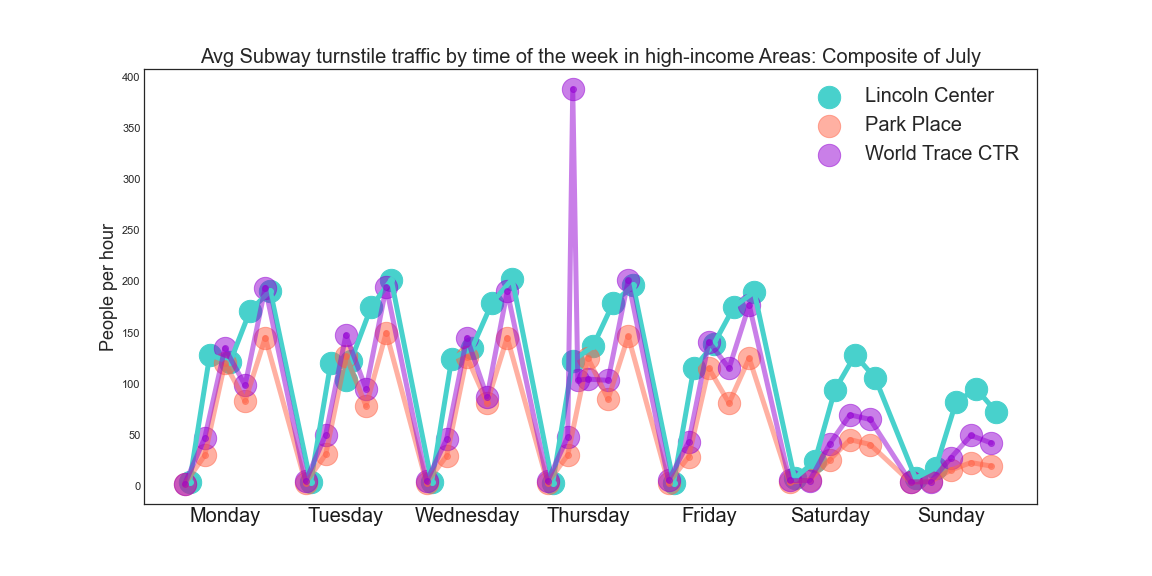

<Figure size 2880x720 with 0 Axes>

In [141]:
# High_income_stations_avg_pp_day_hour[0].head(10)
station_list= High_income_stations_avg_pp_day_hour

plt.figure(figsize=(16,8))

#station_list = turnstile_station['STATION'].unique().tolist()
ticks_x = np.linspace(0.5, 6.5, 7)
days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']
plt.xticks(ticks_x, days, fontsize = '20', color='k');
size_ = 500
alpha_ = .5
#plt.ylim([0, 450])

plt.title('Avg Subway turnstile traffic by time of the week in high-income Areas: Composite of July', fontsize='20')

plt.ylabel('People per hour', fontsize='18')

# plt.scatter( x=turnstile_station[turnstile_station['STATION']==station_list[0]]['Day_hour'], y=turnstile_station[turnstile_station['STATION']==station_list[0]]['People_per_hour'], marker='.', s=(size_,), alpha = alpha_)
# plt.scatter( x=turnstile_station[turnstile_station['STATION']==station_list[1]]['Day_hour'], y=turnstile_station[turnstile_station['STATION']==station_list[1]]['People_per_hour'], marker='.', s=(size_,),  alpha = alpha_)
# plt.scatter( x=turnstile_station[turnstile_station['STATION']==station_list[2]]['Day_hour'], y=turnstile_station[turnstile_station['STATION']==station_list[2]]['People_per_hour'], marker='.', s=(size_,),  alpha = alpha_)
# plt.scatter( x=turnstile_station[turnstile_station['STATION']==station_list[3]]['Day_hour'], y=turnstile_station[turnstile_station['STATION']==station_list[3]]['People_per_hour'], marker='.', s=(size_,),  alpha = alpha_)

# zeroeth = 'Flatiron'
# first='Gramercy'
# second = 'Sixth Ave. Chelsea'
# third = 'Union Sq'

# plt.legend(handles = [zeroeth, first, ], 
#            labels  = ['Line', 'Sine', 'Arcsine'])


# station=3
# plt.scatter( x=station_list[station]['Day_hour'], y=station_list[station]['People_per_hour'], marker='o', s=(size_,), color=colors_[station], alpha=alpha_, label=labels[station])
# plt.plot( station_list[station]['Day_hour'], station_list[station]['People_per_hour'], marker='o', color=colors_[station], alpha=alpha_, lw='5')

station=2
plt.scatter( x=station_list[station]['Day_hour'], y=station_list[station]['People_per_hour'], marker='o', s=(size_,), color=new_colors_[station], alpha=alpha_*2, label=labels[station])
plt.plot( station_list[station]['Day_hour'], station_list[station]['People_per_hour'], marker='o', color=new_colors_[station], alpha=alpha_*2, lw='5')

station=1
plt.scatter( x=station_list[station]['Day_hour'], y=station_list[station]['People_per_hour'], marker='o', s=(size_,), color=new_colors_[station], alpha=alpha_, label=labels[station])
plt.plot( station_list[station]['Day_hour'], station_list[station]['People_per_hour'], marker='o', color=new_colors_[station], alpha=alpha_, lw='5')

station=0
plt.scatter( x=station_list[station]['Day_hour'], y=station_list[station]['People_per_hour'], marker='o', s=(size_,), color=new_colors_[station], alpha=alpha_, label=labels[station])
plt.plot( station_list[station]['Day_hour'], station_list[station]['People_per_hour'], marker='o', color=new_colors_[station], alpha=alpha_, lw='5')

plt.legend(fontsize=20)
plt.show()
#plt.savefig('Avg_Day_hourly_turnstile_fluctuation_in_high_income_areas.svg',transparent=True)
plt.savefig('Avg_Day_hourly_test.svg',transparent=True)
# station_list[1].head()

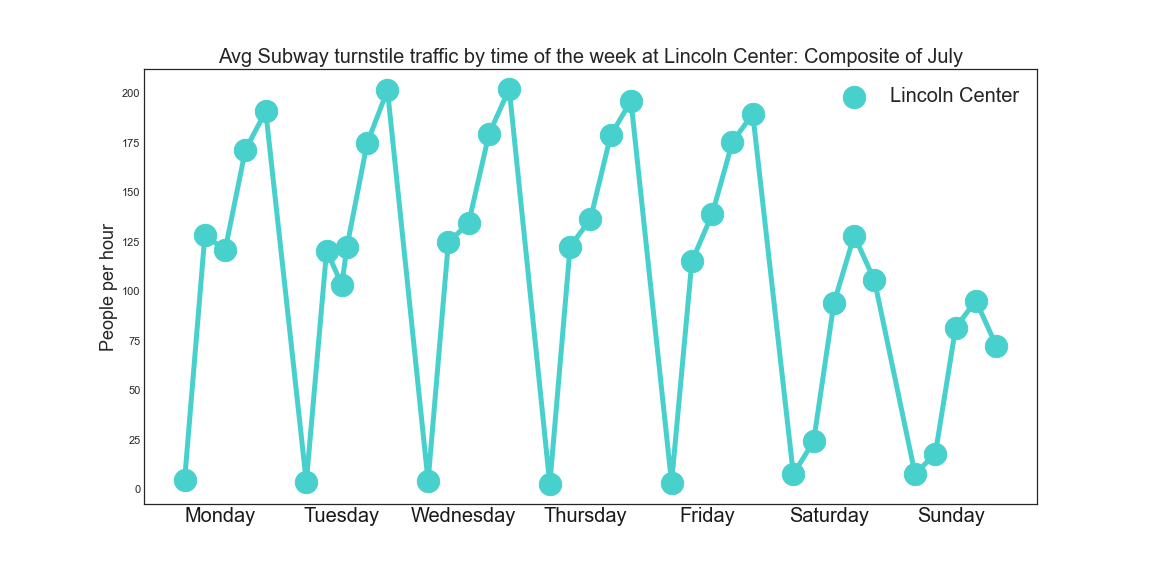

<Figure size 2880x720 with 0 Axes>

In [142]:
plt.figure(figsize=(16,8))

#station_list = turnstile_station['STATION'].unique().tolist()
ticks_x = np.linspace(0.5, 6.5, 7)
days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']
plt.xticks(ticks_x, days, fontsize = '20', color='k');
size_ = 500
alpha_ = .5
#plt.ylim([0, 300])
plt.ylabel('People per hour', fontsize='18')

plt.title('Avg Subway turnstile traffic by time of the week at Lincoln Center: Composite of July', fontsize='20')


station=2
plt.scatter( x=station_list[station]['Day_hour'], y=station_list[station]['People_per_hour'], marker='o', s=(size_,), color=new_colors_[station], alpha=alpha_*2, label=labels[station])
plt.plot( station_list[station]['Day_hour'], station_list[station]['People_per_hour'], marker='o', color=new_colors_[station], alpha=alpha_*2, lw='5')

plt.legend(fontsize=20)
plt.show()
plt.savefig('Avg_Day_hourly_turnstile_fluctuation_at_Lincoln_Center.svg',transparent=True)
plt.savefig('Avg_Day_hourly_turnstile_flux_LincCtr.svg',transparent=True)

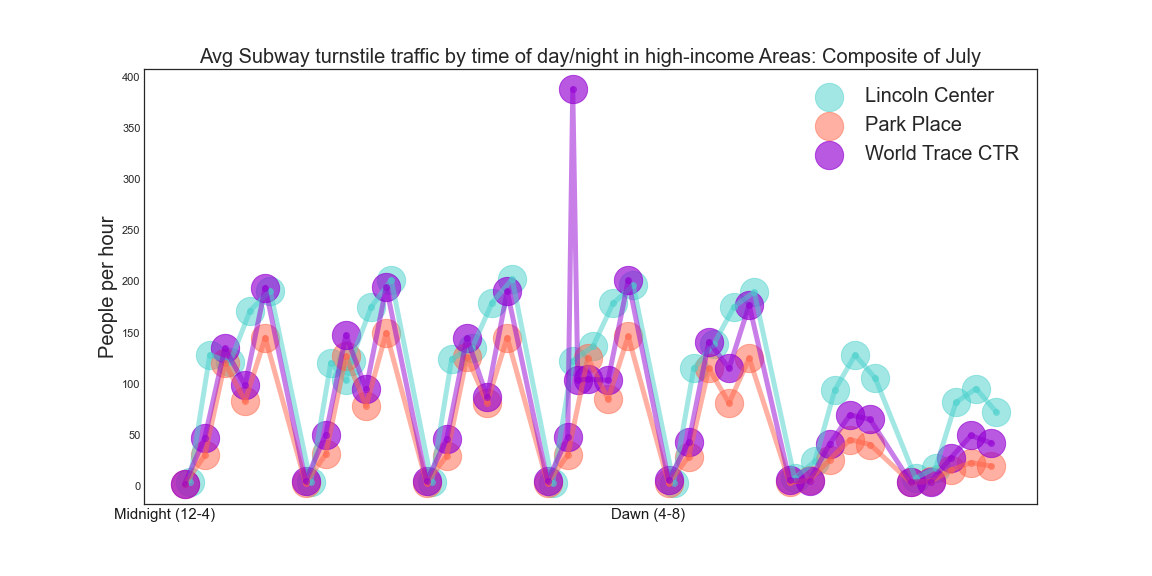

<Figure size 2880x720 with 0 Axes>

In [143]:
station_list = High_income_stations_avg_pp_day_hour

plt.figure(figsize=(16,8))


# ticks_x = np.linspace(0.5, 6.5, 6)
ticks_x = [0, 4, 8, 12, 16, 20]
time_name = dict({0:'Midnight (12-4)', 4:'Dawn (4-8)', 8: 'Morning (8-noon)', 12: 'Afternoon (noon-4)',16:'Dusk (4-8)',20:'Night (8-midnight)'})
times = [time_name[t] for t in ticks_x]
#times =[0, 4, 8, 12, 16, 20]
plt.xticks(ticks_x, times, fontsize = '15', color='k');
size_ = 800
alpha_ = .5

#colors_ = dict({0:bright_green, 1:'blue', 2: 'red', 3: 'orange'})

plt.title('Avg Subway turnstile traffic by time of day/night in high-income Areas: Composite of July', fontsize='20')
plt.ylabel('People per hour', fontsize='20')

#for i in range(len(station_list)):
# alpha_*=.5
# station=3
# plt.scatter( x=station_list[station]['Hour'], y=station_list[station]['People_per_hour'], marker='o', s=(size_,), color=new_colors_[station], alpha=alpha_, label=labels[station])
# plt.plot( station_list[station]['Hour'], station_list[station]['People_per_hour'], marker='o',  color=new_colors_[station], alpha=alpha_, lw='5')

alpha_ = .5

station=2
plt.scatter( x=station_list[station]['Day_hour'], y=station_list[station]['People_per_hour'], marker='o', s=(size_,), color=new_colors_[station], alpha=alpha_, label=labels[station])
plt.plot( station_list[station]['Day_hour'], station_list[station]['People_per_hour'], marker='o',  color=new_colors_[station], alpha=alpha_, lw='5')

station=1
plt.scatter( x=station_list[station]['Day_hour'], y=station_list[station]['People_per_hour'], marker='o', s=(size_,), color=new_colors_[station], alpha=alpha_, label=labels[station])
plt.plot( station_list[station]['Day_hour'], station_list[station]['People_per_hour'], marker='o',  color=new_colors_[station], alpha=alpha_, lw='5')


station=0
plt.scatter( x=station_list[station]['Day_hour'], y=station_list[station]['People_per_hour'], marker='o', s=(size_,), color=new_colors_[station], alpha=alpha_*1.3, label=labels[station])
plt.plot( station_list[station]['Day_hour'], station_list[station]['People_per_hour'], marker='o',  color=new_colors_[station], alpha=alpha_, lw='5')



# plt.scatter( x=turnstile_station[turnstile_station['STATION']==station_list[1]]['Hour'], y=turnstile_station[turnstile_station['STATION']==station_list[1]]['People_per_hour'], marker='.', s=(size_,), alpha=alpha_)
# plt.scatter( x=turnstile_station[turnstile_station['STATION']==station_list[2]]['Hour'], y=turnstile_station[turnstile_station['STATION']==station_list[2]]['People_per_hour'], marker='.', s=(size_,), alpha=alpha_)
# plt.scatter( x=turnstile_station[turnstile_station['STATION']==station_list[3]]['Hour'], y=turnstile_station[turnstile_station['STATION']==station_list[3]]['People_per_hour'], marker='.', s=(size_,), alpha=alpha_)

plt.legend(fontsize='20')
plt.show()
plt.savefig('Avg_Hourly_turnstile_fluctuation_in_High_Income_Areas.svg',transparent=True)

## This dataframe view `turnstile_summary` would be a good one with which to merge income data.  It would also be a good one to make a lat-long scatterplot to indicate traffic.  

Merge (join) the turnstile and stations dataframes.  We probably have too many columms here and should pare down.

## ----------- CC - Geo location and Income visuals --------------

Keep in mind, as noted earlier, the data needs to be at the unique station level in order for this to work properly.
The merge of turnstile to station included a middle step with a xwalk. This is not coming out 1:1 in the merge so we 
need to fix the merge first then provide the graphs.

In [144]:
turnstile_station.head()

,STATION,LINENAME,Datetime,Day_of_week,Day_num,Hour,Day_hour,People_per_hour,GTFS Latitude,GTFS Longitude,income
1,59 ST,NQR456W,2019-04-27 04:00:00,Saturday,5,4,5.166667,6.75,40.762593,-73.967612,112269.0
2,59 ST,NQR456W,2019-04-27 08:00:00,Saturday,5,8,5.333333,14.50,40.762593,-73.967612,112269.0
3,59 ST,NQR456W,2019-04-27 12:00:00,Saturday,5,12,5.500000,44.00,40.762593,-73.967612,112269.0
4,59 ST,NQR456W,2019-04-27 16:00:00,Saturday,5,16,5.666667,82.00,40.762593,-73.967612,112269.0
5,59 ST,NQR456W,2019-04-27 20:00:00,Saturday,5,20,5.833333,82.25,40.762593,-73.967612,112269.0


<AxesSubplot:xlabel='GTFS Longitude', ylabel='GTFS Latitude'>

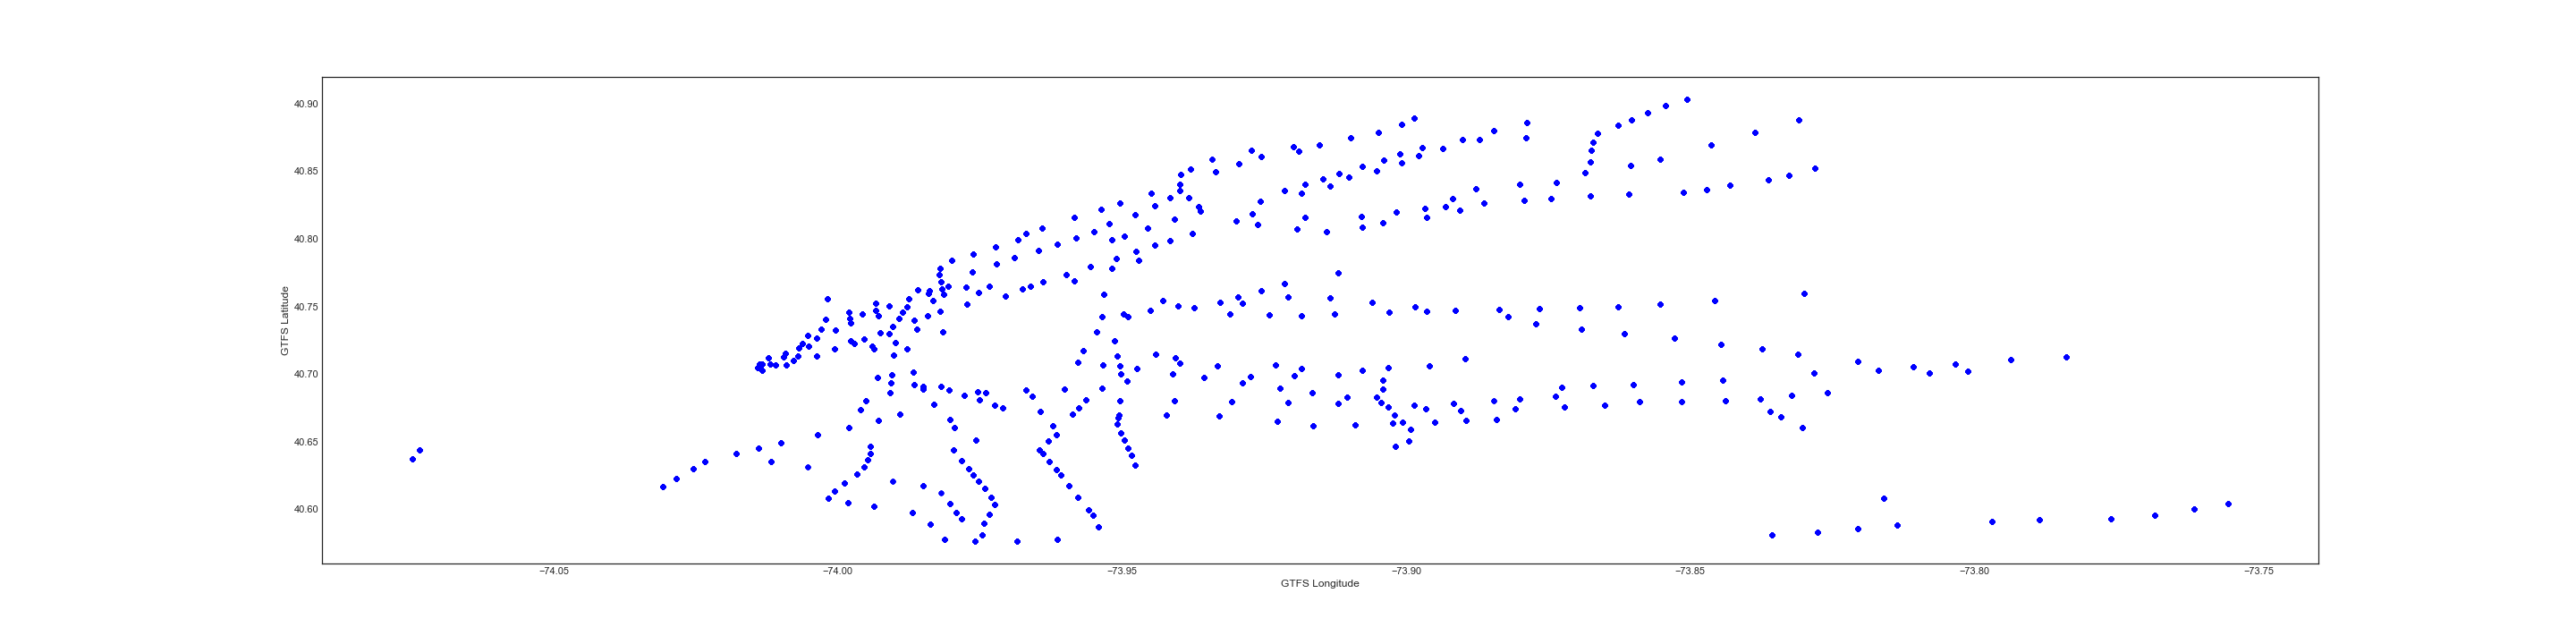

In [145]:
# Very basic plot of lat/long
turnstile_station.plot(kind="scatter", x="GTFS Longitude", y="GTFS Latitude", alpha=0.1, color="blue")
#save_fig("basic lat/lon")

### CC - This is the lat/long graph (stations as bubbles) and income as color
. Need to fix merge to get data at a unique station level
. Can make something more complex by adding map onto the graph

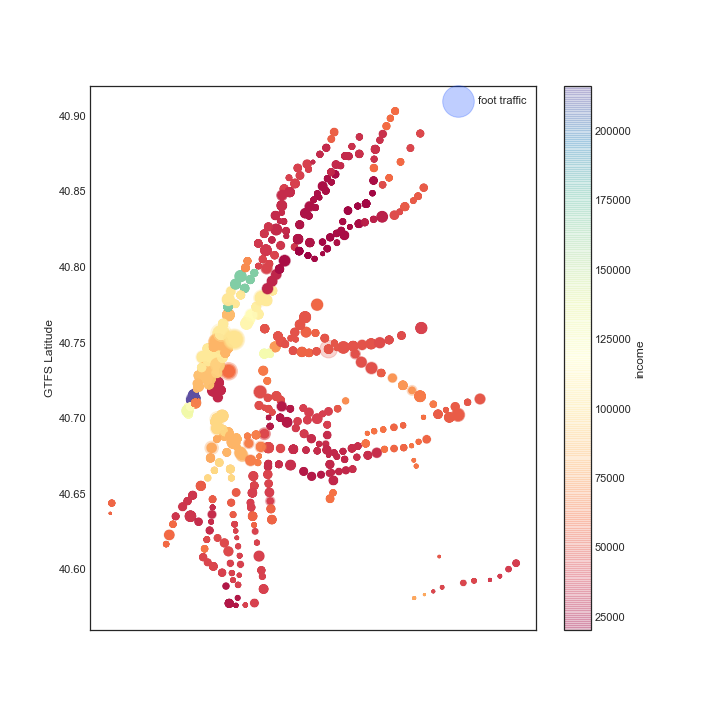

In [146]:
turnstile_station.plot(kind="scatter", x="GTFS Longitude", y="GTFS Latitude",
    s=turnstile_station['People_per_hour']/5, label="foot traffic",
    c="income", cmap=plt.get_cmap("Spectral"),
    colorbar=True, alpha=0.25, figsize=(10,10),
    
                       
)
plt.legend()
#save_fig("Plot of Traffic and Income")
plt.show()

# Top Stations by Income

In [147]:
station_level = turnstile_station.groupby(['STATION'])[['income']].agg('mean').reset_index().sort_values(('income'),ascending=False)

In [148]:
station_level.sort_values(by=['income'],ascending=False)

,STATION,income
191,CORTLANDT ST,216037.0
179,CHAMBERS ST,216037.0
184,CITY HALL,216037.0
374,WTC-CORTLANDT,216037.0
373,WORLD TRADE CTR,216037.0
...,...,...
327,RIT-MANHATTAN,NaN
328,RIT-ROOSEVELT,NaN
349,THIRTY ST,NaN
350,THIRTY THIRD ST,NaN


## Top 20 Stations by Income

In [149]:
station_level.head(20)

,STATION,income
191,CORTLANDT ST,216037.000000
374,WTC-CORTLANDT,216037.000000
373,WORLD TRADE CTR,216037.000000
179,CHAMBERS ST,216037.000000
184,CITY HALL,216037.000000
91,66 ST-LINCOLN,170630.000000
309,PARK PLACE,148673.493878
115,96 ST,143225.074571
158,BOWLING GREEN,129574.000000
360,VERNON-JACKSON,125871.000000


## ------------ CC - END income geo graphs ------------

In [150]:
## IGNORE THIS!!

#turnstile_station = df.merge(stations, left_on="STATION", right_on="Stop Name")
turnstile_station = turnstile_summary.merge(stations[['income', 'Stop Name']], left_on="STATION", right_on="Stop Name")
turnstile_station.drop(columns=["Stop Name"], inplace=True)
turnstile_station

NameError: name 'turnstile_summary' is not defined

For this to be useful regarding income levels in neighborhoods (which will probably exists by zip code), 

we'd have to merge this station we'd have to use library that gets zip code from lat and longitude

I believe the one to use is probably geopy: 
[geopy](https://geopy.readthedocs.io/en/stable/)

These might or not be helpful:

[income by zip](https://www.incomebyzipcode.com/newyork)

[open data nyc](https://opendata.cityofnewyork.us/)    

# I think the code below here should be re-oriented to draw instead from `turnstile_summary` using its column `People_per_hour`

In [151]:
df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,Datetime,Traffic_running_total
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/27/2019,00:00:00,REGULAR,7035249,2384833,2019-04-27 00:00:00,9420082
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/27/2019,04:00:00,REGULAR,7035269,2384840,2019-04-27 04:00:00,9420109
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/27/2019,08:00:00,REGULAR,7035292,2384875,2019-04-27 08:00:00,9420167
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/27/2019,12:00:00,REGULAR,7035392,2384951,2019-04-27 12:00:00,9420343
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/27/2019,16:00:00,REGULAR,7035651,2385020,2019-04-27 16:00:00,9420671


In [152]:
#Check for abnormalities. Less than zero are changed to positive and greater than the max are reset to 0
def daily_counts(row, max_counter):
    counter = row["ENTRIES"] - row["PREV_ENTRIES"]
    if counter < 0:
        counter = -counter
    if counter > max_counter:
        counter = min(row["ENTRIES"], row["PREV_ENTRIES"])
    if counter > max_counter:
        return 0
    return counter

In [153]:
#sort "ENTRIES" by including "Datetime"
(df.groupby(["C/A", "UNIT", "SCP", "STATION", "Datetime"])
    .ENTRIES.count()
    .reset_index()
    .sort_values("ENTRIES", ascending=False));

In [154]:
#Sort ENTRIES and keep the ending value of the day
df_daily = df.groupby(["C/A", "UNIT", "SCP", "STATION", "DATE"])\
                .ENTRIES.first().reset_index().copy()

In [155]:
df_4hourly = df.groupby(["C/A", "UNIT", "SCP", "STATION", "Datetime"])\
                .ENTRIES.first().reset_index().copy()

In [156]:
df_4hourly.head()

,C/A,UNIT,SCP,STATION,Datetime,ENTRIES
0,A002,R051,02-00-00,59 ST,2019-04-27 00:00:00,7035249
1,A002,R051,02-00-00,59 ST,2019-04-27 04:00:00,7035269
2,A002,R051,02-00-00,59 ST,2019-04-27 08:00:00,7035292
3,A002,R051,02-00-00,59 ST,2019-04-27 12:00:00,7035392
4,A002,R051,02-00-00,59 ST,2019-04-27 16:00:00,7035651


In [157]:
#Grab the previous row's DATE and ENTRIES and pull into current column for all columns.
df_daily[["PREV_DATE", "PREV_ENTRIES"]] = (df_daily.groupby(["C/A", "UNIT", "SCP", "STATION"])["DATE", "ENTRIES"]\
                                          .transform(lambda grp: grp.shift(1)));

<ipython-input-157-60c4191346a3>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_daily[["PREV_DATE", "PREV_ENTRIES"]] = (df_daily.groupby(["C/A", "UNIT", "SCP", "STATION"])["DATE", "ENTRIES"]\


In [158]:
df_daily.head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES
0,A002,R051,02-00-00,59 ST,04/27/2019,7035249,NaN,NaN
1,A002,R051,02-00-00,59 ST,04/28/2019,7036100,04/27/2019,7035249.0
2,A002,R051,02-00-00,59 ST,04/29/2019,7036746,04/28/2019,7036100.0
3,A002,R051,02-00-00,59 ST,04/30/2019,7038242,04/29/2019,7036746.0
4,A002,R051,02-00-00,59 ST,05/01/2019,7039729,04/30/2019,7038242.0


In [159]:
#Use daily_counts function 
df_daily["DAILY_ENTRIES"] = df_daily.apply(daily_counts, axis=1, max_counter=1000000);

In [160]:
df_daily.head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES,DAILY_ENTRIES
0,A002,R051,02-00-00,59 ST,04/27/2019,7035249,NaN,NaN,NaN
1,A002,R051,02-00-00,59 ST,04/28/2019,7036100,04/27/2019,7035249.0,851.0
2,A002,R051,02-00-00,59 ST,04/29/2019,7036746,04/28/2019,7036100.0,646.0
3,A002,R051,02-00-00,59 ST,04/30/2019,7038242,04/29/2019,7036746.0,1496.0
4,A002,R051,02-00-00,59 ST,05/01/2019,7039729,04/30/2019,7038242.0,1487.0


In [161]:
#Dataframe for STATION and DATE and sum on DAILY ENTRIES.

df_daily_stations = df_daily.groupby(['STATION', 'DATE'])['DAILY_ENTRIES'].sum().reset_index().sort_values(['DATE'])

In [162]:
df_median = df_daily_stations.groupby(['STATION'])['DAILY_ENTRIES'].agg(['median']).reset_index().sort_values(['median'], ascending=False)
df_median_10 = df_median[:10]

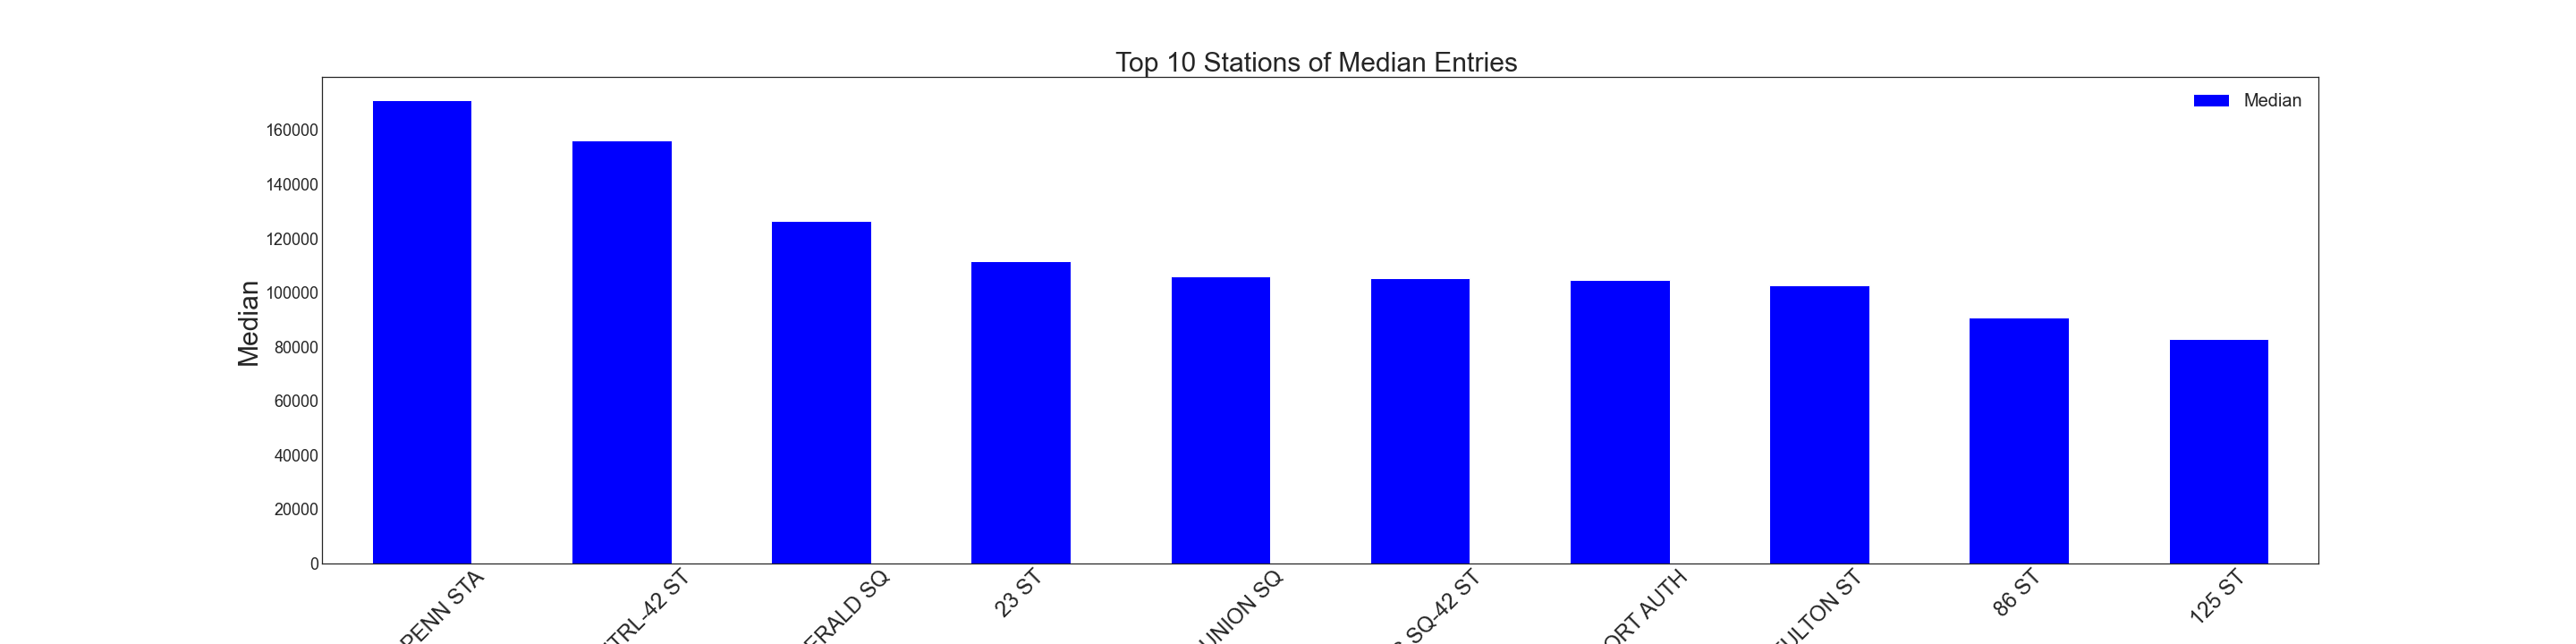

In [163]:
#top ten stations bar plot

df_median_10.plot.bar(x='STATION',y='median',color='blue')
plt.xlabel('Stations', fontsize=30)
plt.ylabel('Median', fontsize=30)
plt.title("Top 10 Stations of Median Entries ", fontsize=30)
plt.xticks(fontsize=24)
plt.yticks(fontsize=18)
plt.xticks(rotation=45)
plt.legend(["Median"], prop={"size":20})

plt.show()

In [164]:
df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,Datetime,Traffic_running_total
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/27/2019,00:00:00,REGULAR,7035249,2384833,2019-04-27 00:00:00,9420082
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/27/2019,04:00:00,REGULAR,7035269,2384840,2019-04-27 04:00:00,9420109
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/27/2019,08:00:00,REGULAR,7035292,2384875,2019-04-27 08:00:00,9420167
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/27/2019,12:00:00,REGULAR,7035392,2384951,2019-04-27 12:00:00,9420343
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/27/2019,16:00:00,REGULAR,7035651,2385020,2019-04-27 16:00:00,9420671


In [165]:
df_median = df.groupby('STATION')['ENTRIES'].sum().sort_values(ascending=False)
df_median.head(10)

STATION
42 ST-PORT AUTH    695244068540
125 ST             565408752935
TIMES SQ-42 ST     503509422311
3 AV-149 ST        432828650724
CHAMBERS ST        423871595142
104 ST             408972895636
34 ST-HERALD SQ    401659414959
14 ST              387004501618
183 ST             385357287968
FULTON ST          354736628561
Name: ENTRIES, dtype: int64

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


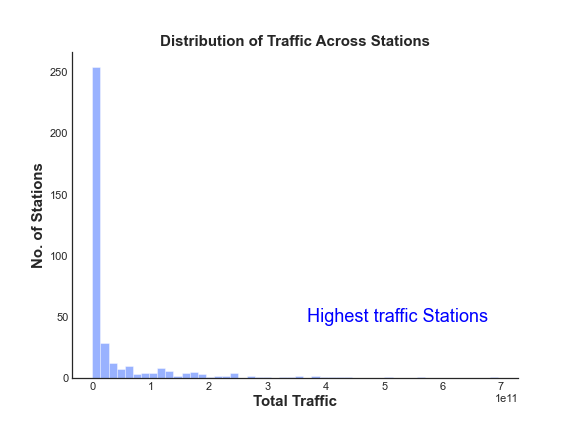

In [166]:
fig1 = plt.figure(figsize=[8,6])
ax1 = sns.distplot(df_median,bins=50,kde=False)
#plt.xlim([0,410000])
plt.ylabel('No. of Stations',fontsize=15, weight='bold')
plt.xlabel('Total Traffic', fontsize=15, weight='bold')
ax1.annotate('Highest traffic Stations', xy=(0.73, 0.08), xytext=(0.73, 0.16), xycoords='axes fraction', 
            fontsize=18, ha='center', va='bottom', arrowprops=dict(arrowstyle='-[, widthB=9.0, lengthB=1', lw=8.0),color='blue')                            
                            
plt.title('Distribution of Traffic Across Stations',fontsize=15,weight='bold')
sns.despine()

plt.savefig('histplot.png',transparent=True, bbox_inches='tight')

In [167]:
#Gives top 5
df.groupby(['LINENAME', 'STATION']).sum().sort_values(by='ENTRIES',ascending=False).head(10)

,,ENTRIES,EXITS,Traffic_running_total
LINENAME,STATION,,,
ACENQRS1237W,42 ST-PORT AUTH,686398725881,563515334168,1249914060049
1237ACENQRSW,TIMES SQ-42 ST,491726303960,269861326304,761587630264
25,3 AV-149 ST,432828650724,285849695452,718678346176
BDFMNQRW,34 ST-HERALD SQ,401659414959,504520136316,906179551275
4,183 ST,385357287968,230165704628,615522992596
123,72 ST,298621347569,399783865293,698405212862
MR,ELMHURST AV,271418889427,392349296486,663768185913
ACJZ2345,FULTON ST,265949474272,174057702020,440007176292
JZ,104 ST,265260752740,213293921343,478554674083
